In [31]:
# ============================================================================
# AIRLINE CUSTOMER SATISFACTION - MILESTONE 1
# German University in Cairo - CSEN 903
# ============================================================================

# ============================================================================
# INSTALL REQUIRED PACKAGES
# ============================================================================

import sys
import subprocess

def install_package(package):
    """Install package if not already installed"""
    try:
        if package == 'vaderSentiment':
            __import__('vaderSentiment')
        else:
            __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✓ {package} installed successfully")

print("Checking and installing required packages...")
print("="*70)
install_package('vaderSentiment')
install_package('shap')
install_package('lime')
print("="*70)
print("✓ All required packages ready!\n")

# ============================================================================
# PART 1: SETUP & DATA LOADING
# ============================================================================

print("="*70)
print("IMPORTING LIBRARIES")
print("="*70)

# Core data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("✓ Core libraries imported")

# For sentiment analysis
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("✓ VADER Sentiment Analysis imported")
except ImportError as e:
    print(f"❌ Error importing VADER: {e}")
    print("   Please restart kernel and run again")

# For ML models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_curve, auc)
print("✓ Scikit-learn libraries imported")

# For Neural Networks
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    print(f"✓ TensorFlow {tf.__version__} imported")
except ImportError:
    print("⚠ TensorFlow not available - Neural Network will be skipped")

# For XAI (Explainable AI)
try:
    import shap
    print("✓ SHAP imported")
except ImportError as e:
    print(f"❌ Error importing SHAP: {e}")

try:
    from lime import lime_tabular
    print("✓ LIME imported")
except ImportError as e:
    print(f"❌ Error importing LIME: {e}")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✓ Visualization settings configured")

print("\n" + "="*70)
print("ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("="*70)

# Display versions
print("\nLibrary Versions:")
print(f"  Python: {sys.version.split()[0]}")
print(f"  Pandas: {pd.__version__}")
print(f"  NumPy: {np.__version__}")
import matplotlib
print(f"  Matplotlib: {matplotlib.__version__}")
print(f"  Seaborn: {sns.__version__}")
import sklearn
print(f"  Scikit-learn: {sklearn.__version__}")
try:
    print(f"  TensorFlow: {tf.__version__}")
except:
    print(f"  TensorFlow: Not available")
try:
    print(f"  SHAP: {shap.__version__}")
except:
    print(f"  SHAP: Version not available")

# Quick VADER test
print("\n" + "="*70)
print("TESTING VADER SENTIMENT ANALYZER")
print("="*70)
try:
    analyzer = SentimentIntensityAnalyzer()
    test_text = "This is an excellent flight with great service!"
    test_score = analyzer.polarity_scores(test_text)
    print(f"Test text: '{test_text}'")
    print(f"Sentiment scores: {test_score}")
    print("✓ VADER is working correctly!")
except Exception as e:
    print(f"❌ VADER test failed: {e}")
    print("   Please restart kernel and try again")

# ============================================================================
# LOAD DATASETS
# ============================================================================

"""
We have 4 CSV files:
1. AirlineScrappedReview.csv (use cleaned version from CMS)
2. Customer_comment.csv
3. Passanger_booking_data.csv
4. Survey_data_Inflight_Satisfaction_Score.csv
"""

# Import kagglehub
try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    print("✓ KaggleHub imported")
    use_kagglehub = True
except ImportError:
    print("Installing kagglehub...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub", "-q"])
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    print("✓ KaggleHub installed and imported")
    use_kagglehub = True

# Initialize dataset variables
df_reviews = None
df_comments = None
df_booking = None
df_survey = None

# Load each dataset
print("\n" + "="*70)
print("LOADING DATASETS")
print("="*70)

# Method 1: Try kagglehub
if use_kagglehub:
    try:
        # Dataset 1: Airline Scrapped Review
        print("\nLoading AirlineScrappedReview.csv...")
        df_reviews = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "/kaggle/input/cleanedcms/AirlineScrappedReview_Cleaned.csv"
        )
        print(f"✓ Loaded AirlineScrappedReview.csv: {df_reviews.shape}")

        # Dataset 2: Customer Comments
        print("\nLoading Customer_comment.csv...")
        df_comments = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "manishkumar7432698/airline-passangers-booking-data",
            "Customer_comment.csv"
        )
        print(f"✓ Loaded Customer_comment.csv: {df_comments.shape}")

        # Dataset 3: Passenger Booking Data
        print("\nLoading Passanger_booking_data.csv...")
        df_booking = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "manishkumar7432698/airline-passangers-booking-data",
            "Passanger_booking_data.csv"
        )
        print(f"✓ Loaded Passanger_booking_data.csv: {df_booking.shape}")

        # Dataset 4: Survey Data - Inflight Satisfaction
        print("\nLoading Survey_data_Inflight_Satisfaction_Score.csv...")
        df_survey = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "manishkumar7432698/airline-passangers-booking-data",
            "Survey_data_Inflight_Satisfaction_Score.csv"
        )
        print(f"✓ Loaded Survey_data_Inflight_Satisfaction_Score.csv: {df_survey.shape}")
        
        use_kagglehub = True  # Success!

    except Exception as e:
        print(f"\n⚠ KaggleHub loading failed: {e}")
        print("Trying alternative method...")
        use_kagglehub = False

# Method 2: Direct file paths (fallback)
if not use_kagglehub or df_reviews is None:
    print("\nUsing direct file path method...")
    try:
        base_path = '/kaggle/input/airline-passangers-booking-data/'
        
        df_reviews = pd.read_csv(base_path + 'AirlineScrappedReview.csv')
        print(f"✓ Loaded AirlineScrappedReview.csv: {df_reviews.shape}")
        
        df_comments = pd.read_csv(base_path + 'Customer_comment.csv')
        print(f"✓ Loaded Customer_comment.csv: {df_comments.shape}")
        
        df_booking = pd.read_csv(base_path + 'Passanger_booking_data.csv')
        print(f"✓ Loaded Passanger_booking_data.csv: {df_booking.shape}")
        
        df_survey = pd.read_csv(base_path + 'Survey_data_Inflight_Satisfaction_Score.csv')
        print(f"✓ Loaded Survey_data_Inflight_Satisfaction_Score.csv: {df_survey.shape}")
        
    except FileNotFoundError as e:
        print(f"❌ File not found: {e}")
        print("\n📌 IMPORTANT: Please add the dataset to your Kaggle notebook:")
        print("   1. Click '+ Add Data' in the right panel")
        print("   2. Search for 'airline-passangers-booking-data'")
        print("   3. Add the dataset by manishkumar7432698")
        print("   4. Rerun this cell")
    except Exception as e:
        print(f"❌ Error loading files: {e}")

# Verify all datasets loaded
print("\n" + "="*70)
print("DATASET LOADING VERIFICATION")
print("="*70)

datasets_loaded = {
    'AirlineScrappedReview': df_reviews is not None,
    'Customer_comment': df_comments is not None,
    'Passanger_booking_data': df_booking is not None,
    'Survey_data_Inflight_Satisfaction': df_survey is not None
}

all_loaded = all(datasets_loaded.values())

for name, loaded in datasets_loaded.items():
    status = "✓" if loaded else "❌"
    print(f"{status} {name}: {'Loaded' if loaded else 'NOT LOADED'}")

if all_loaded:
    print("\n✅ All datasets loaded successfully!")
else:
    print("\n⚠ WARNING: Some datasets failed to load!")
    print("   Please check the error messages above and fix the issue.")
    print("   The notebook may not work correctly without all datasets.")

print("="*70)

# ============================================================================
# INITIAL DATA EXPLORATION
# ============================================================================

print("\n" + "="*70)
print("INITIAL DATA EXPLORATION")
print("="*70)

# Function to explore dataset
def explore_dataset(df, name):
    """Explore and display information about a dataset"""
    if df is None:
        print(f"\n⚠ {name}: Dataset not loaded - skipping exploration")
        return
    
    print(f"\n{'='*70}")
    print(f"Dataset: {name}")
    print(f"{'='*70}")
    print(f"Shape: {df.shape} (rows: {df.shape[0]:,}, columns: {df.shape[1]})")
    
    print(f"\nColumn Names and Types:")
    print(df.dtypes)
    
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    
    print(f"\nMissing Values:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("No missing values!")
    
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")
    
    print(f"\nBasic Statistics (numerical columns):")
    if len(df.select_dtypes(include=[np.number]).columns) > 0:
        print(df.describe())
    else:
        print("No numerical columns found")

# Explore each dataset (only if loaded)
if df_reviews is not None:
    explore_dataset(df_reviews, "AirlineScrappedReview")
else:
    print("\n⚠ AirlineScrappedReview not loaded - cannot explore")

if df_comments is not None:
    explore_dataset(df_comments, "Customer_comment")
else:
    print("\n⚠ Customer_comment not loaded - cannot explore")

if df_booking is not None:
    explore_dataset(df_booking, "Passanger_booking_data")
else:
    print("\n⚠ Passanger_booking_data not loaded - cannot explore")

if df_survey is not None:
    explore_dataset(df_survey, "Survey_data_Inflight_Satisfaction")
else:
    print("\n⚠ Survey_data_Inflight_Satisfaction not loaded - cannot explore")

# Final status
print("\n" + "="*70)
if all_loaded:
    print("✓ Initial data exploration complete!")
else:
    print("⚠ Data exploration complete (with some datasets missing)")
    print("  Please fix loading errors before proceeding to next parts")
print("="*70)





# Robust loader for the survey CSV (replace the previous loading-cell)
import os
import pandas as pd

def find_csv_candidates(root="/kaggle/input", keywords=None):
    """Return list of CSV file paths under `root` that contain any of the keywords (case-insensitive)."""
    if keywords is None:
        keywords = ["survey", "satisfaction", "inflight", "survey_data"]
    candidates = []
    for dirpath, dirnames, filenames in os.walk(root):
        for f in filenames:
            if f.lower().endswith('.csv'):
                path = os.path.join(dirpath, f)
                # include if any keyword in filename
                low = f.lower()
                if any(k.lower() in low for k in keywords):
                    candidates.append(path)
    return sorted(set(candidates))

def list_all_csvs(root="/kaggle/input"):
    files = []
    for dirpath, dirnames, filenames in os.walk(root):
        for f in filenames:
            if f.lower().endswith('.csv'):
                files.append(os.path.join(dirpath, f))
    return sorted(files)

def try_read_csv(path):
    """Try reading a CSV with safe fallbacks for encoding/engine."""
    try:
        df = pd.read_csv(path)
        return df, None
    except Exception as e:
        # try other common encodings & engine
        for enc in ['utf-8', 'latin1', 'cp1252']:
            try:
                df = pd.read_csv(path, encoding=enc)
                return df, None
            except Exception:
                continue
        # try python engine with error replacement
        try:
            df = pd.read_csv(path, engine='python', encoding='utf-8', error_bad_lines=False, warn_bad_lines=True)
            return df, None
        except Exception as e2:
            return None, (e, e2)

# 1) Show all CSVs found under /kaggle/input (helpful for debugging paths)
print("Listing CSV files under /kaggle/input (first 200 shown):")
all_csvs = list_all_csvs("/kaggle/input")
for i, p in enumerate(all_csvs[:200], 1):
    print(f"{i:03d}. {p}")
if not all_csvs:
    print(">> No CSV files found under /kaggle/input. Make sure you added the dataset to the notebook (Use '+ Add data').")

# 2) Find candidate survey CSVs by keywords
candidates = find_csv_candidates("/kaggle/input", keywords=["survey", "satisfaction", "inflight", "survey_data", "Survey"])
print("\nCandidate survey CSVs (by filename keywords):")
if candidates:
    for i, p in enumerate(candidates, 1):
        print(f"{i:03d}. {p}")
else:
    print(">> No candidates matched keywords. You can still check the full listing above.")

# 3) If exactly one candidate, try to load it; if multiple, try each and pick the one that looks like a survey
df_survey = None
if candidates:
    for path in candidates:
        print(f"\nTrying to load: {path}")
        df_try, errs = try_read_csv(path)
        if df_try is not None:
            # quick heuristic: require at least 2 columns and >0 rows
            if df_try.shape[1] >= 2 and df_try.shape[0] > 0:
                df_survey = df_try
                print(f"✓ Loaded survey candidate: {path} -> shape {df_survey.shape}")
                break
            else:
                print(f"  Loaded but shape looks small: {df_try.shape} — continuing to next candidate")
        else:
            print(f"  Failed to read {path}. Errors: {errs}")
else:
    # fallback: ask user to choose from all CSVs (if any)
    if all_csvs:
        print("\nNo keyword-matching candidates found. Trying the first CSV in the dataset as a last resort.")
        fallback = all_csvs[0]
        df_try, errs = try_read_csv(fallback)
        if df_try is not None:
            df_survey = df_try
            print(f"✓ Loaded fallback CSV: {fallback} -> shape {df_survey.shape}")
        else:
            print(f"❌ Failed to read fallback CSV: {fallback}. Errors: {errs}")

# 4) Final check & exploration
if df_survey is None:
    print("\n❌ Could not load any survey CSV automatically.")
    print("   Next steps you should try:")
    print("    1) In the right-side Kaggle panel click '+ Add data' and ensure the dataset 'airline-passangers-booking-data' is added.")
    print("    2) Re-run the listing cell above and check the printed filenames for the exact survey CSV filename.")
    print("    3) If you see the correct file path from the listing, load it explicitly, e.g.:")
    print("         df_survey = pd.read_csv('/kaggle/input/your-folder/Survey_data_Inflight_Satisfaction_Score.csv')")
    print("    4) If the CSV has spaces in the name, use the exact filename (spaces matter).")
else:
    # Basic exploration (same as your explore_dataset function but inline)
    print("\n" + "="*60)
    print("Survey Data - Quick Explore")
    print("="*60)
    print("Shape:", df_survey.shape)
    print("\nColumns and dtypes:")
    print(df_survey.dtypes)
    print("\nFirst 5 rows:")
    display(df_survey.head(5))
    print("\nMissing values (columns with >0 missing):")
    missing = df_survey.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("No missing values detected")
    print("\nDuplicate rows:", df_survey.duplicated().sum())


Checking and installing required packages...
✓ vaderSentiment already installed
✓ shap already installed
✓ lime already installed
✓ All required packages ready!

IMPORTING LIBRARIES
✓ Core libraries imported
✓ VADER Sentiment Analysis imported
✓ Scikit-learn libraries imported
✓ TensorFlow 2.18.0 imported
✓ SHAP imported
✓ LIME imported
✓ Visualization settings configured

ALL LIBRARIES IMPORTED SUCCESSFULLY!

Library Versions:
  Python: 3.11.13
  Pandas: 2.2.3
  NumPy: 1.26.4
  Matplotlib: 3.7.2
  Seaborn: 0.12.2
  Scikit-learn: 1.2.2
  TensorFlow: 2.18.0
  SHAP: 0.44.1

TESTING VADER SENTIMENT ANALYZER
Test text: 'This is an excellent flight with great service!'
Sentiment scores: {'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'compound': 0.8439}
✓ VADER is working correctly!
✓ KaggleHub imported

LOADING DATASETS

Loading AirlineScrappedReview.csv...

⚠ KaggleHub loading failed: load_dataset() missing 1 required positional argument: 'path'
Trying alternative method...

Using direct file pa

,flight_number,origin_station_code,destination_station_code,record_locator,scheduled_departure_date,question_text,score,satisfaction_type,driver_sub_group1,driver_sub_group2,...,equipment_type_code,ua_uax,actual_flown_miles,haul_type,departure_gate,arrival_gate,international_domestic_indicator,response_group,media_provider,hub_spoke
0,3802,MKX,ORX,CYXXJJ,9/1/2022,How satisfied were you with the food & beverag...,2,Dissatisfied,food & beverage,food and beverage satisfaction,...,CRZ,UAX,67,Short,C12,F10,Domestic,non-member,NaN,spoke departure
1,4645,COX,DEX,DRXXMH,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,E75,UAX,72,Short,5,B60,Domestic,member,GOGO,spoke departure
2,5236,COX,DEX,DEXXS1,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,E75,UAX,72,Short,7,A71,Domestic,member,GOGO,spoke departure
3,4686,DEX,COX,PXXXLH,9/1/2022,How satisfied were you with the food & beverag...,3,Dissatisfied,food & beverage,food and beverage satisfaction,...,CRJ,UAX,72,Short,B82,5,Domestic,member,NaN,hub departure
4,671,DEX,COX,KZXXH5,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,19F,UA,72,Short,B24,3,Domestic,member,PANASONIC,hub departure



Missing values (columns with >0 missing):
satisfaction_type        12111
cabin_name               19980
entity                       3
loyalty_program_level    11616
departure_gate              97
arrival_gate               527
media_provider            1539
dtype: int64

Duplicate rows: 0


In [32]:
# Full data-cleaning script (copy into one notebook cell or split as needed)

import pandas as pd
import numpy as np
from typing import Any, Optional, Tuple

# -----------------------------
# (Optional) LOAD DATASETS
# -----------------------------
# Uncomment & update paths if running locally / in Kaggle
# df_reviews = pd.read_csv("/kaggle/input/.../AirlineScrappedReview.csv")
# df_comments = pd.read_csv("/kaggle/input/.../Customer_comment.csv")
# df_booking = pd.read_csv("/kaggle/input/.../Passanger_booking_data.csv")
# df_survey = pd.read_csv("/kaggle/input/.../Survey_data_Inflight_Satisfaction.csv")

# If you already have these DataFrame variables in the environment, keep them as is.
# If not, they will be treated as None and skipped safely.

# -----------------------------
# Helpers & safe-copy
# -----------------------------
def safe_copy(df: Optional[pd.DataFrame], name: str) -> Optional[pd.DataFrame]:
    """Return a copy if df is a DataFrame, otherwise print warning and return None."""
    if df is None:
        print(f"⚠️  Warning: {name} is not loaded (None). Skipping.")
        return None
    if not isinstance(df, pd.DataFrame):
        print(f"⚠️  Warning: {name} is not a pandas DataFrame (type: {type(df)}). Skipping.")
        return None
    print(f"✓ {name} loaded: shape {df.shape}")
    return df.copy()

def safe_mode(series: pd.Series, fallback: Any = "Unknown") -> Any:
    """Return the first mode or fallback if no mode exists."""
    modes = series.mode(dropna=True)
    if modes.empty:
        return fallback
    return modes.iloc[0]

def fill_categorical(series: pd.Series, fallback: Any = "Unknown") -> pd.Series:
    """Fill categorical (object) series with mode or fallback."""
    try:
        fill_val = safe_mode(series, fallback)
        return series.fillna(fill_val)
    except Exception:
        return series.fillna(fallback)

def fill_numeric_with_median(series: pd.Series, fallback: float = 0.0) -> pd.Series:
    """Fill numeric series with median (fallback to 0 if median can't be computed)."""
    try:
        med = series.median(skipna=True)
        if pd.isna(med):
            med = fallback
        return series.fillna(med)
    except Exception:
        return series.fillna(fallback)

def normalize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names: strip, replace spaces with underscore."""
    df = df.rename(columns=lambda c: str(c).strip().replace(' ', '_'))
    return df

def trim_whitespace_in_object_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Strip leading/trailing whitespace for string columns."""
    obj_cols = df.select_dtypes(include=['object', 'string']).columns
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip().replace({'nan': np.nan})
    return df

# -----------------------------
# Create safe copies
# -----------------------------
df_reviews_clean  = safe_copy(globals().get("df_reviews"), "AirlineScrappedReview")
df_comments_clean = safe_copy(globals().get("df_comments"), "Customer_comment")
df_booking_clean  = safe_copy(globals().get("df_booking"), "Passanger_booking_data")
df_survey_clean   = safe_copy(globals().get("df_survey"), "Survey_data_Inflight_Satisfaction")

print("\nSetup complete. Proceeding to cleaning for loaded datasets.\n")

# -----------------------------
# Generic cleaning function
# -----------------------------
def clean_dataframe(df: pd.DataFrame,
                    name: str,
                    fill_review_text: bool = False,
                    review_text_col: str = "Review_content",
                    review_title_col: str = "Review_title",
                    drop_high_missing_pct: float = 50.0,
                    auto_drop_high_missing: bool = False) -> Tuple[pd.DataFrame, dict]:
    """
    General cleaning routine with documented decisions.
    Returns cleaned df and a log dict of actions taken.
    """
    log = {"name": name, "original_shape": df.shape, "actions": []}
    
    # Normalize column names + trim whitespace
    df = normalize_column_names(df)
    df = trim_whitespace_in_object_cols(df)
    log["actions"].append("Normalized column names and trimmed whitespace")
    
    # Document missing value counts
    missing_series = df.isnull().sum()
    missing_info = missing_series[missing_series > 0].sort_values(ascending=False)
    log["missing_before"] = missing_info.to_dict()
    if not missing_info.empty:
        log["actions"].append(f"Found {len(missing_info)} columns with missing values")
    
    # Decision: drop columns with > drop_high_missing_pct missing values (flag or drop)
    cols_to_drop = []
    total_rows = len(df)
    for col, miss in missing_info.items():
        pct = (miss / total_rows) * 100
        if pct > drop_high_missing_pct:
            cols_to_drop.append(col)
    
    if cols_to_drop:
        if auto_drop_high_missing:
            df.drop(columns=cols_to_drop, inplace=True)
            log["actions"].append(f"Auto-dropped columns with >{drop_high_missing_pct}% missing: {cols_to_drop}")
        else:
            log["actions"].append(f"Flagged columns with >{drop_high_missing_pct}% missing (not auto-dropped): {cols_to_drop}")
    
    # Special case: fill review text/title placeholders if asked and columns exist
    if fill_review_text:
        if review_text_col in df.columns:
            cnt = df[review_text_col].isnull().sum()
            if cnt > 0:
                df[review_text_col] = df[review_text_col].fillna("No review provided")
                log["actions"].append(f"Filled {cnt} missing '{review_text_col}' with 'No review provided'")
        if review_title_col in df.columns:
            cnt = df[review_title_col].isnull().sum()
            if cnt > 0:
                df[review_title_col] = df[review_title_col].fillna("No title")
                log["actions"].append(f"Filled {cnt} missing '{review_title_col}' with 'No title'")
    
    # Fill remaining missing values column-wise
    for col in df.columns:
        miss = df[col].isnull().sum()
        if miss == 0:
            continue
        if df[col].dtype == 'object' or pd.api.types.is_string_dtype(df[col]):
            fill_val = safe_mode(df[col], fallback="Unknown")
            df[col] = df[col].fillna(fill_val)
            log["actions"].append(f"Filled {miss} missing in object column '{col}' with mode/fallback '{fill_val}'")
        elif pd.api.types.is_numeric_dtype(df[col]):
            med = df[col].median(skipna=True)
            if pd.isna(med):
                med = 0.0
            df[col] = df[col].fillna(med)
            log["actions"].append(f"Filled {miss} missing in numeric column '{col}' with median {med}")
        else:
            # For other dtypes (datetime, category, etc.)
            if pd.api.types.is_datetime64_any_dtype(df[col]):
                # Fill datetimes with forward fill then backward fill as fallback
                df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
                df[col] = df[col].fillna(pd.NaT)
                log["actions"].append(f"Attempted to fill datetime column '{col}' with ffill/bfill")
            else:
                df[col] = df[col].fillna("Unknown")
                log["actions"].append(f"Filled {miss} missing in other column '{col}' with 'Unknown'")
    
    # Remove exact duplicate rows
    dup_before = df.duplicated().sum()
    if dup_before > 0:
        df.drop_duplicates(inplace=True)
    dup_after = df.duplicated().sum()
    log["actions"].append(f"Removed {dup_before - dup_after} duplicate rows (before: {dup_before})")
    
    # Final shape and missing check
    log["cleaned_shape"] = df.shape
    log["missing_after"] = int(df.isnull().sum().sum())
    log["rows_removed"] = log["original_shape"][0] - log["cleaned_shape"][0]
    
    return df, log

# -----------------------------
# Run cleaning per dataset (only if loaded)
# -----------------------------
results_logs = []
if df_reviews_clean is not None:
    df_reviews_clean, log_reviews = clean_dataframe(
        df_reviews_clean,
        name="AirlineScrappedReview",
        fill_review_text=True,
        review_text_col="Review_content",
        review_title_col="Review_title",
        drop_high_missing_pct=50.0,
        auto_drop_high_missing=False
    )
    results_logs.append(log_reviews)

if df_comments_clean is not None:
    df_comments_clean, log_comments = clean_dataframe(
        df_comments_clean,
        name="Customer_comment",
        fill_review_text=False,
        drop_high_missing_pct=50.0,
        auto_drop_high_missing=False
    )
    results_logs.append(log_comments)

if df_booking_clean is not None:
    df_booking_clean, log_booking = clean_dataframe(
        df_booking_clean,
        name="Passanger_booking_data",
        fill_review_text=False,
        drop_high_missing_pct=50.0,
        auto_drop_high_missing=False
    )
    results_logs.append(log_booking)

if df_survey_clean is not None:
    df_survey_clean, log_survey = clean_dataframe(
        df_survey_clean,
        name="Survey_data_Inflight_Satisfaction",
        fill_review_text=False,
        drop_high_missing_pct=50.0,
        auto_drop_high_missing=False
    )
    results_logs.append(log_survey)

# -----------------------------
# Summary report
# -------------------------


✓ AirlineScrappedReview loaded: shape (3580, 9)
✓ Customer_comment loaded: shape (9424, 17)
✓ Passanger_booking_data loaded: shape (50002, 14)
✓ Survey_data_Inflight_Satisfaction loaded: shape (47074, 31)

Setup complete. Proceeding to cleaning for loaded datasets.




SENTIMENT ANALYSIS

Applying VADER sentiment analysis to reviews...
✓ Sentiment analysis complete!

Sentiment Distribution:
Sentiment_Analysis
Positive    2030
Negative    1436
Neutral       40
Name: count, dtype: int64

Sentiment Percentages:
Sentiment_Analysis
Positive    57.900742
Negative    40.958357
Neutral      1.140901
Name: proportion, dtype: float64


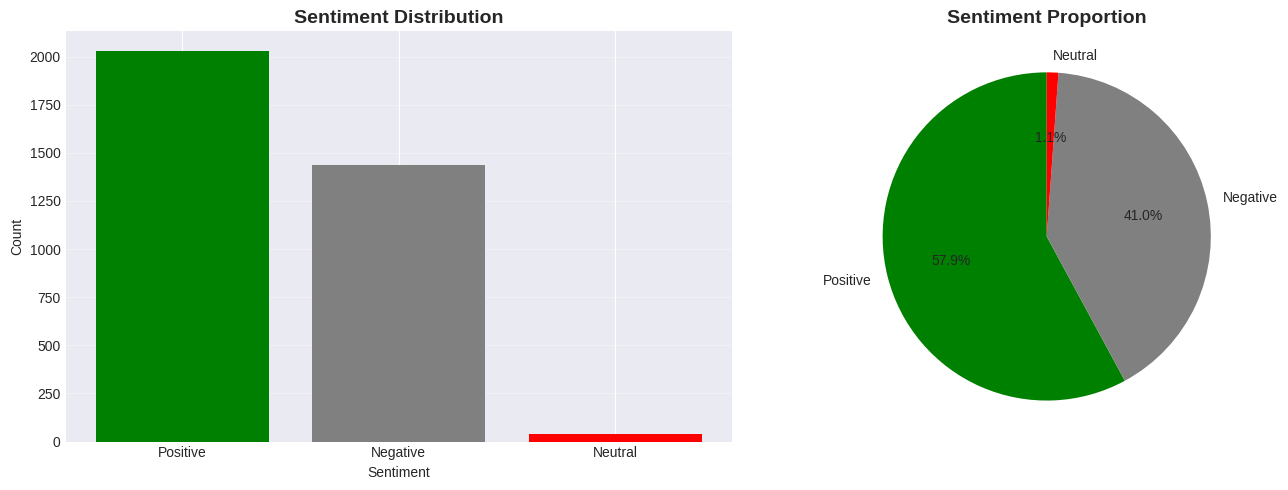

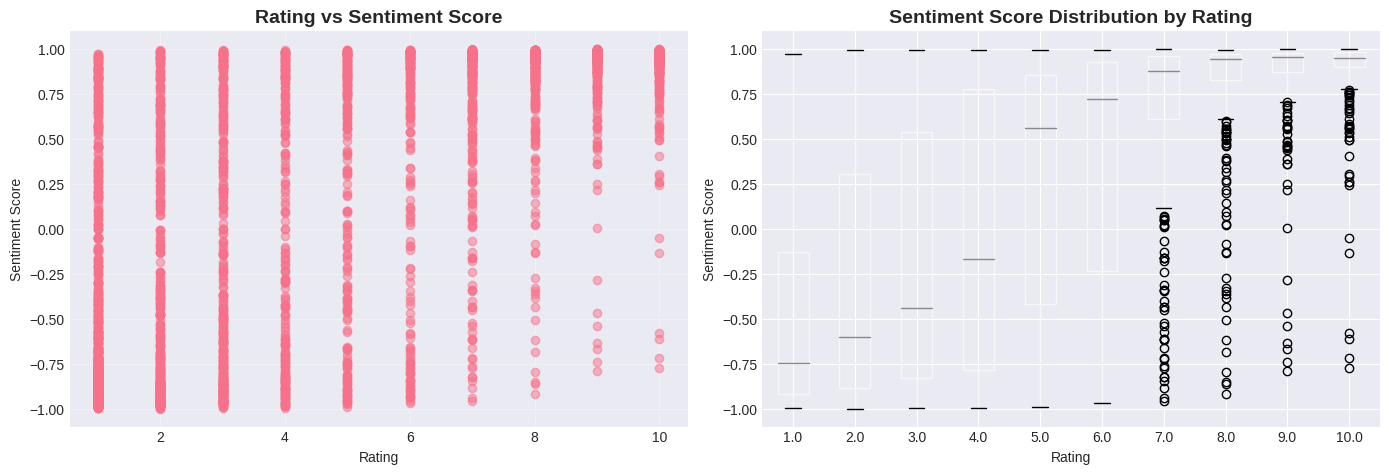


DATA ENGINEERING QUESTIONS

--- Question 1: Flight Routes and Booking Distribution ---

Q1a: What are the top 10 most popular flight routes?

Top 10 Most Popular Routes:
Route
Economy Class            1538
Business Class            682
Premium Economy           185
First Class               143
Amsterdam to London         6
New York to London          6
London to Toronto           5
Los Angeles to London       5
London to Delhi             5
London to Tampa             5
Name: count, dtype: int64


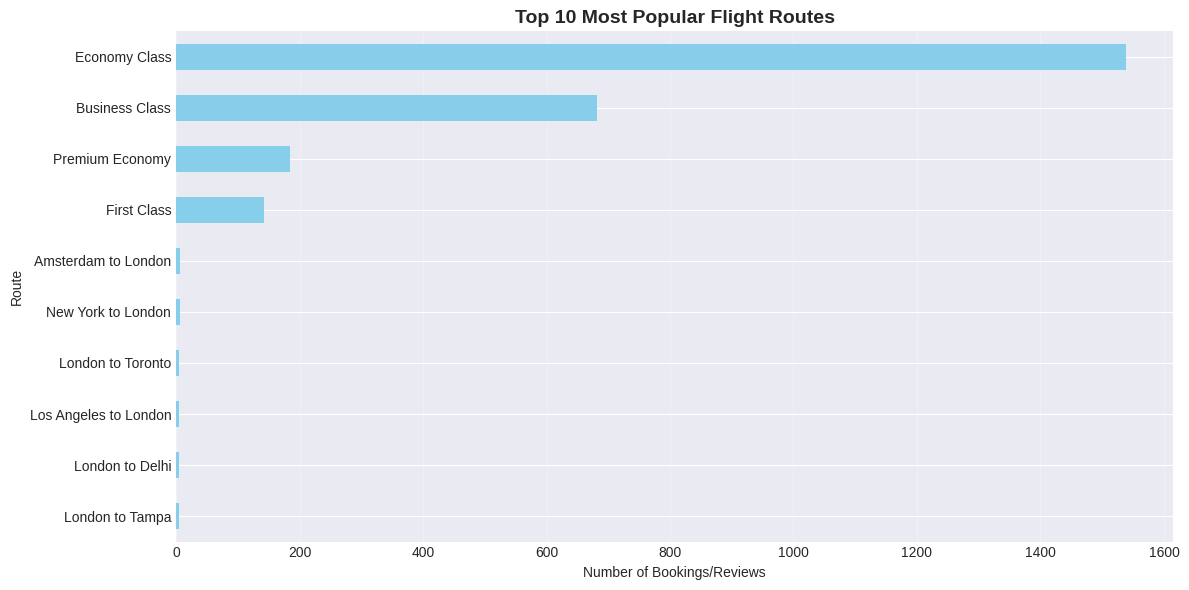


Q1b: What is the distribution of bookings across flight hours?


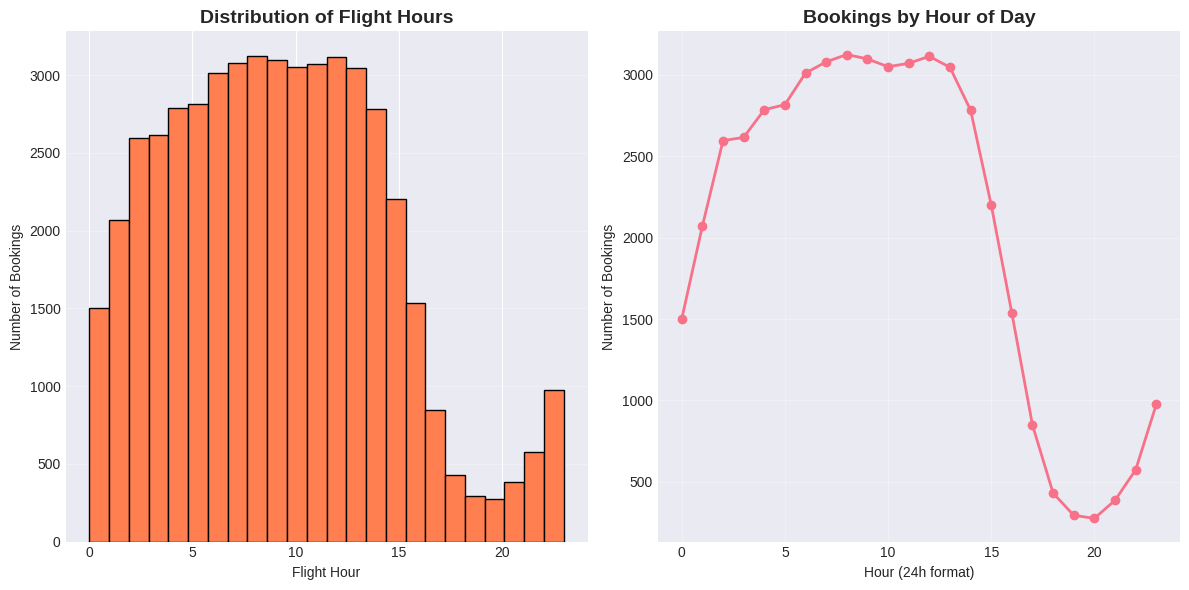


Flight Hour Statistics:
  Most popular hour: 8
  Average flight hour: 9.07
  Median flight hour: 9.0

--- Question 2: Traveler Type & Class Ratings ---

Q2: Which traveler type and class combination yields highest/lowest ratings?

Average Ratings by Traveler Type and Class:
                                                       mean  median  count
Traveller_type Class                                                      
767-300        Family Leisure                          6.00     6.0      1
777            Business                                9.00     9.0      1
               Couple Leisure                          1.00     1.0      2
777-200        Couple Leisure                          1.00     1.0      1
777-300        Solo Leisure                            9.00     9.0      1
...                                                     ...     ...    ...
Solo Leisure   Los Angeles to London to Paris to Rome  1.00     1.0      1
               Premium Economy                   

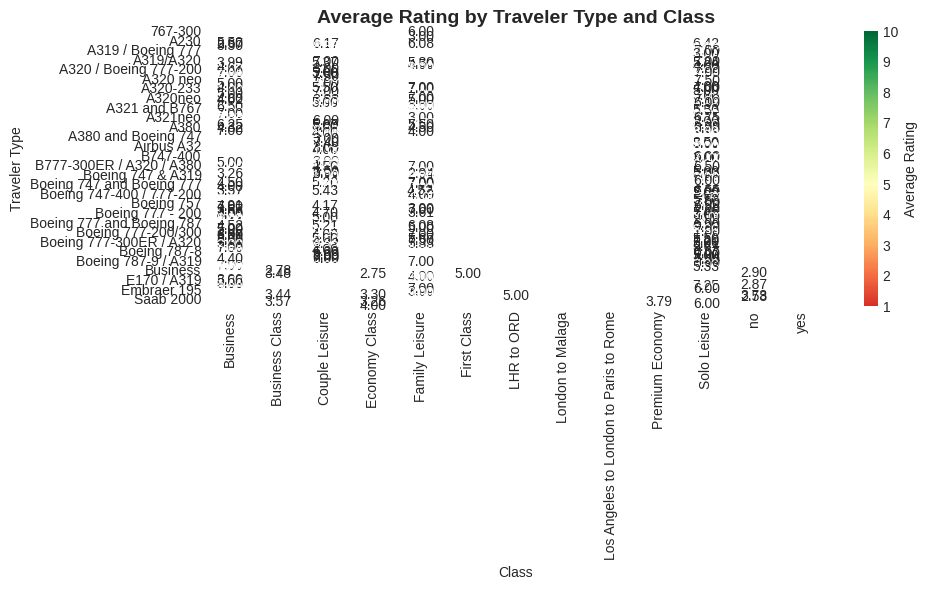

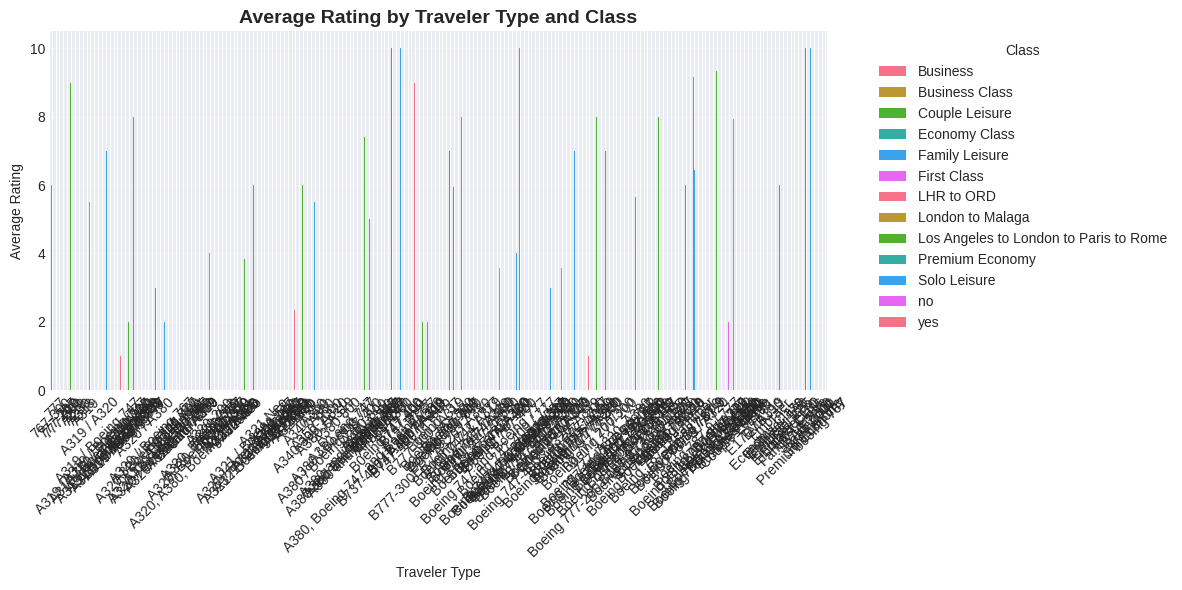


✓ Highest Rating: ('A319 / Boeing 777-300', 'Solo Leisure') with 10.00
✓ Lowest Rating: ('777', 'Couple Leisure') with 1.00

✓ Data engineering questions answered!


In [33]:
# ============================================================================
# PART 3: SENTIMENT ANALYSIS
# ============================================================================

"""
Objective: Add Sentiment_Analysis column to AirlineScrappedReview
Using: VADER (Valence Aware Dictionary and sEntiment Reasoner)
"""

print("\n" + "="*70)
print("SENTIMENT ANALYSIS")
print("="*70)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    """
    Apply VADER sentiment analysis to text
    Returns compound score ranging from -1 (most negative) to +1 (most positive)
    """
    if pd.isna(text) or text == "No review provided":
        return 0.0  # Neutral for missing reviews
    
    scores = analyzer.polarity_scores(str(text))
    return scores['compound']  # Compound score is the normalized score

def classify_sentiment(score):
    """
    Classify sentiment based on compound score:
    - Positive: score >= 0.05
    - Negative: score <= -0.05
    - Neutral: -0.05 < score < 0.05
    """
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to Review_content
print("\nApplying VADER sentiment analysis to reviews...")
df_reviews_clean['Sentiment_Score'] = df_reviews_clean['Review_content'].apply(get_sentiment_score)
df_reviews_clean['Sentiment_Analysis'] = df_reviews_clean['Sentiment_Score'].apply(classify_sentiment)

print("✓ Sentiment analysis complete!")

# Display sentiment distribution
print("\nSentiment Distribution:")
print(df_reviews_clean['Sentiment_Analysis'].value_counts())
print("\nSentiment Percentages:")
print(df_reviews_clean['Sentiment_Analysis'].value_counts(normalize=True) * 100)

# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
sentiment_counts = df_reviews_clean['Sentiment_Analysis'].value_counts()
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'gray', 'red'])
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=['green', 'gray', 'red'], startangle=90)
axes[1].set_title('Sentiment Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Relationship between Rating and Sentiment Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(df_reviews_clean['Rating'], df_reviews_clean['Sentiment_Score'], alpha=0.5)
axes[0].set_title('Rating vs Sentiment Score', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Sentiment Score')
axes[0].grid(alpha=0.3)

# Box plot
df_reviews_clean.boxplot(column='Sentiment_Score', by='Rating', ax=axes[1])
axes[1].set_title('Sentiment Score Distribution by Rating', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Sentiment Score')
plt.suptitle('')

plt.tight_layout()
plt.show()

# ============================================================================
# PART 4: DATA ENGINEERING QUESTIONS
# ============================================================================

print("\n" + "="*70)
print("DATA ENGINEERING QUESTIONS")
print("="*70)

# ============================================================================
# QUESTION 1: Top 10 Most Popular Flight Routes & Booking Distribution
# ============================================================================

print("\n--- Question 1: Flight Routes and Booking Distribution ---")

# Q1a: Top 10 most popular flight routes
print("\nQ1a: What are the top 10 most popular flight routes?")

# Count routes from reviews dataset
if 'Route' in df_reviews_clean.columns:
    route_counts = df_reviews_clean['Route'].value_counts().head(10)
    print("\nTop 10 Most Popular Routes:")
    print(route_counts)
    
    # Visualize
    plt.figure(figsize=(12, 6))
    route_counts.plot(kind='barh', color='skyblue')
    plt.title('Top 10 Most Popular Flight Routes', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Bookings/Reviews')
    plt.ylabel('Route')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Q1b: Distribution of bookings across flight hours
print("\nQ1b: What is the distribution of bookings across flight hours?")

if 'flight_hour' in df_booking_clean.columns:
    # Plot distribution of flight hours
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    df_booking_clean['flight_hour'].hist(bins=24, color='coral', edgecolor='black')
    plt.title('Distribution of Flight Hours', fontsize=14, fontweight='bold')
    plt.xlabel('Flight Hour')
    plt.ylabel('Number of Bookings')
    plt.grid(axis='y', alpha=0.3)
    
    # Count plot
    plt.subplot(1, 2, 2)
    hour_counts = df_booking_clean['flight_hour'].value_counts().sort_index()
    plt.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=6)
    plt.title('Bookings by Hour of Day', fontsize=14, fontweight='bold')
    plt.xlabel('Hour (24h format)')
    plt.ylabel('Number of Bookings')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("\nFlight Hour Statistics:")
    print(f"  Most popular hour: {df_booking_clean['flight_hour'].mode()[0]}")
    print(f"  Average flight hour: {df_booking_clean['flight_hour'].mean():.2f}")
    print(f"  Median flight hour: {df_booking_clean['flight_hour'].median()}")

# ============================================================================
# QUESTION 2: Traveler Type & Class Rating Analysis
# ============================================================================

print("\n--- Question 2: Traveler Type & Class Ratings ---")
print("\nQ2: Which traveler type and class combination yields highest/lowest ratings?")

# Create pivot table
if 'Traveller_type' in df_reviews_clean.columns and 'Class' in df_reviews_clean.columns:
    traveler_class_ratings = df_reviews_clean.groupby(['Traveller_type', 'Class'])['Rating'].agg([
        'mean', 'median', 'count'
    ]).round(2)
    
    print("\nAverage Ratings by Traveler Type and Class:")
    print(traveler_class_ratings)
    
    # Find highest and lowest
    pivot_mean = df_reviews_clean.pivot_table(
        values='Rating', 
        index='Traveller_type', 
        columns='Class', 
        aggfunc='mean'
    )
    
    print("\nPivot Table - Mean Ratings:")
    print(pivot_mean.round(2))
    
    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_mean, annot=True, fmt='.2f', cmap='RdYlGn', center=5,
                linewidths=1, linecolor='white', cbar_kws={'label': 'Average Rating'})
    plt.title('Average Rating by Traveler Type and Class', fontsize=14, fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Traveler Type')
    plt.tight_layout()
    plt.show()
    
    # Bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    df_reviews_clean.groupby(['Traveller_type', 'Class'])['Rating'].mean().unstack().plot(
        kind='bar', ax=ax, rot=45
    )
    ax.set_title('Average Rating by Traveler Type and Class', fontsize=14, fontweight='bold')
    ax.set_xlabel('Traveler Type')
    ax.set_ylabel('Average Rating')
    ax.legend(title='Class', bbox_to_anchor=(1.05, 1))
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Identify highest and lowest
    max_rating = traveler_class_ratings['mean'].max()
    min_rating = traveler_class_ratings['mean'].min()
    max_combo = traveler_class_ratings[traveler_class_ratings['mean'] == max_rating].index[0]
    min_combo = traveler_class_ratings[traveler_class_ratings['mean'] == min_rating].index[0]
    
    print(f"\n✓ Highest Rating: {max_combo} with {max_rating:.2f}")
    print(f"✓ Lowest Rating: {min_combo} with {min_rating:.2f}")

print("\n✓ Data engineering questions answered!")


FEATURE SELECTION & ENGINEERING

--- Creating Target Variable ---

Target Variable Distribution:
Satisfaction
0    1836
1    1670
Name: count, dtype: int64

Percentages:
Satisfaction
0    52.36737
1    47.63263
Name: proportion, dtype: float64


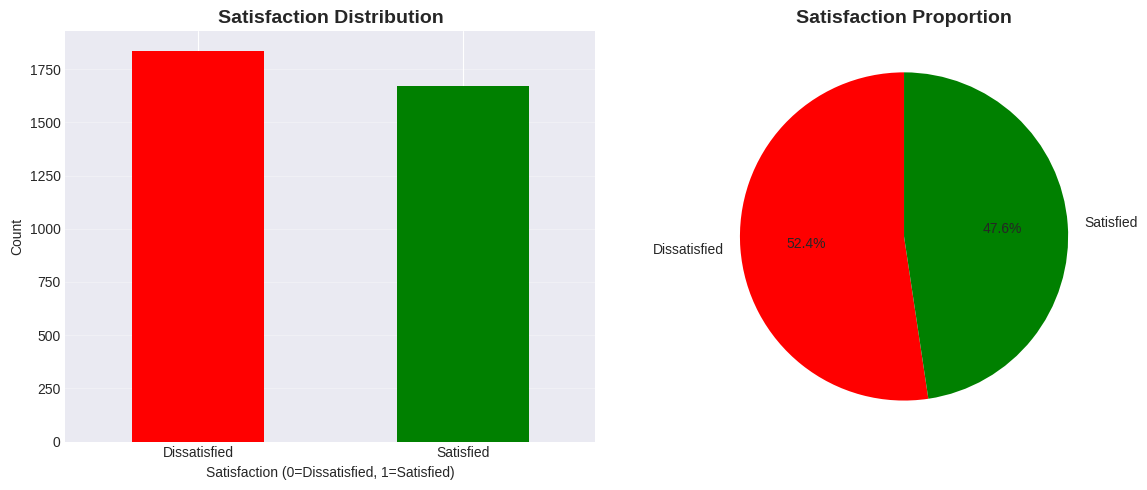


--- Feature Selection ---

✓ Feature: Traveller_type
  Justification: Different traveler types have different needs/expectations


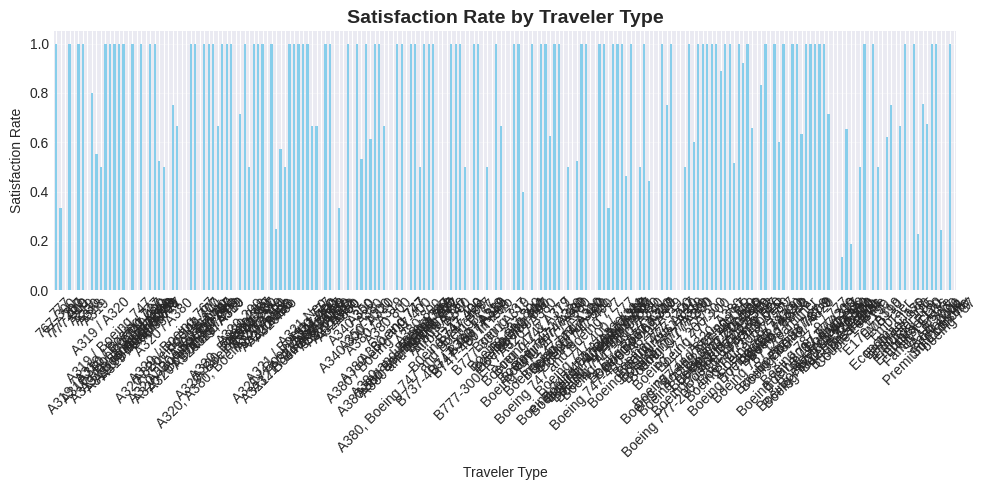


✓ Feature: Class
  Justification: Service quality varies by cabin class


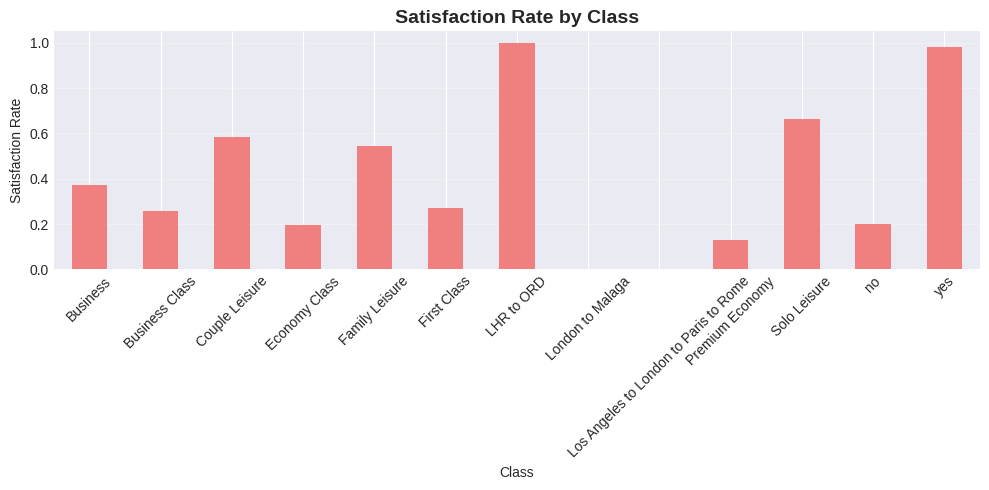


✓ Feature: Verified
  Justification: Verification status may affect review authenticity


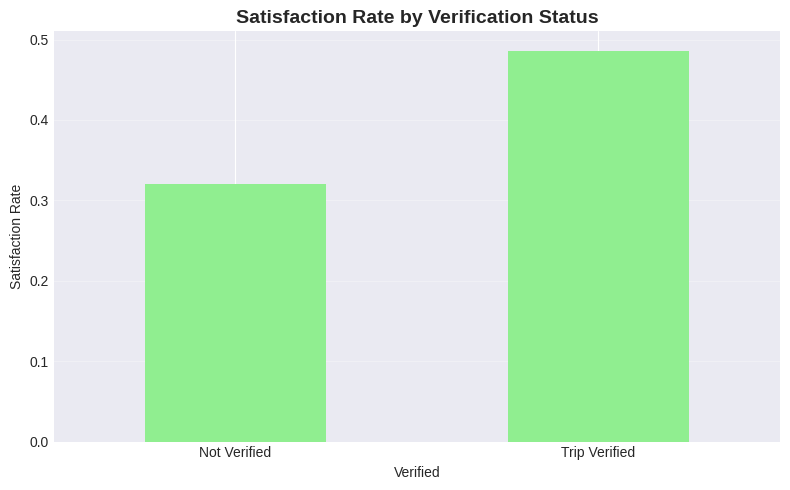


✓ Feature: Sentiment_Score
  Justification: Direct measure of sentiment from review text


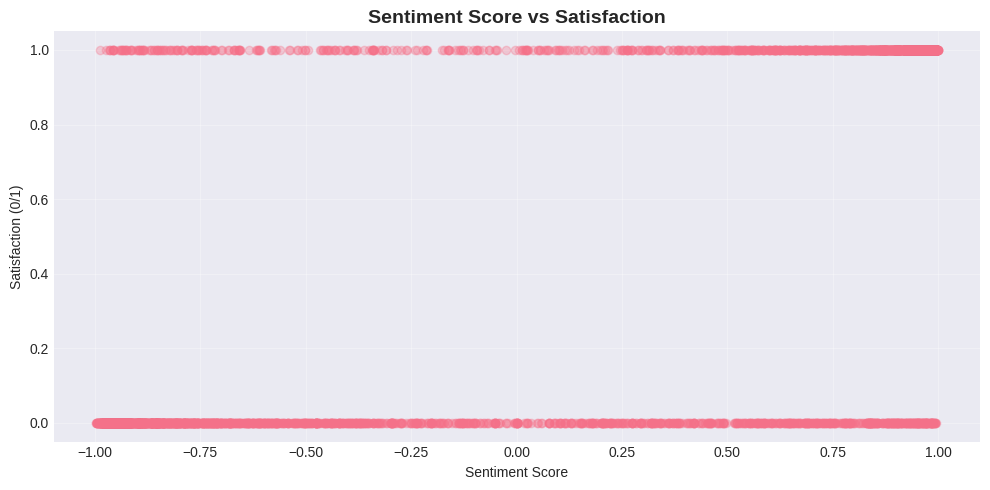

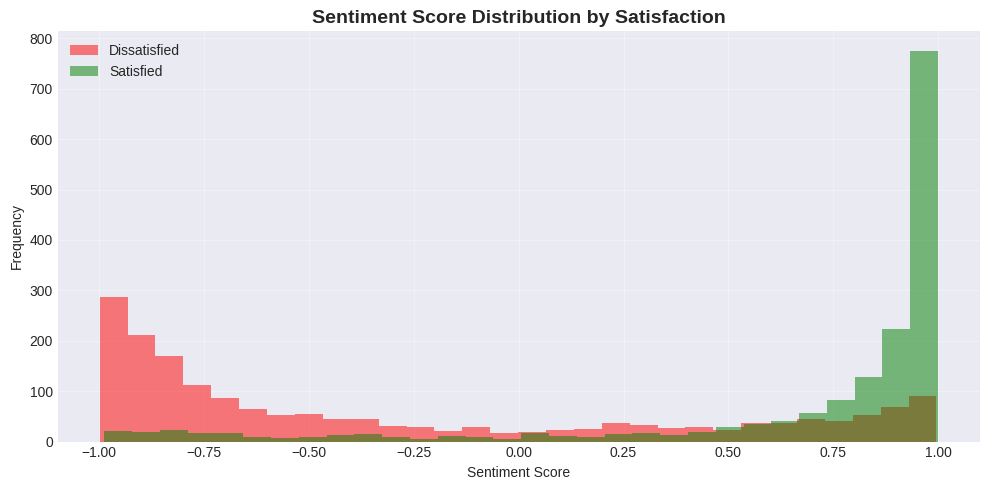


✓ Feature: Route
  Justification: Route-specific operational factors affect satisfaction


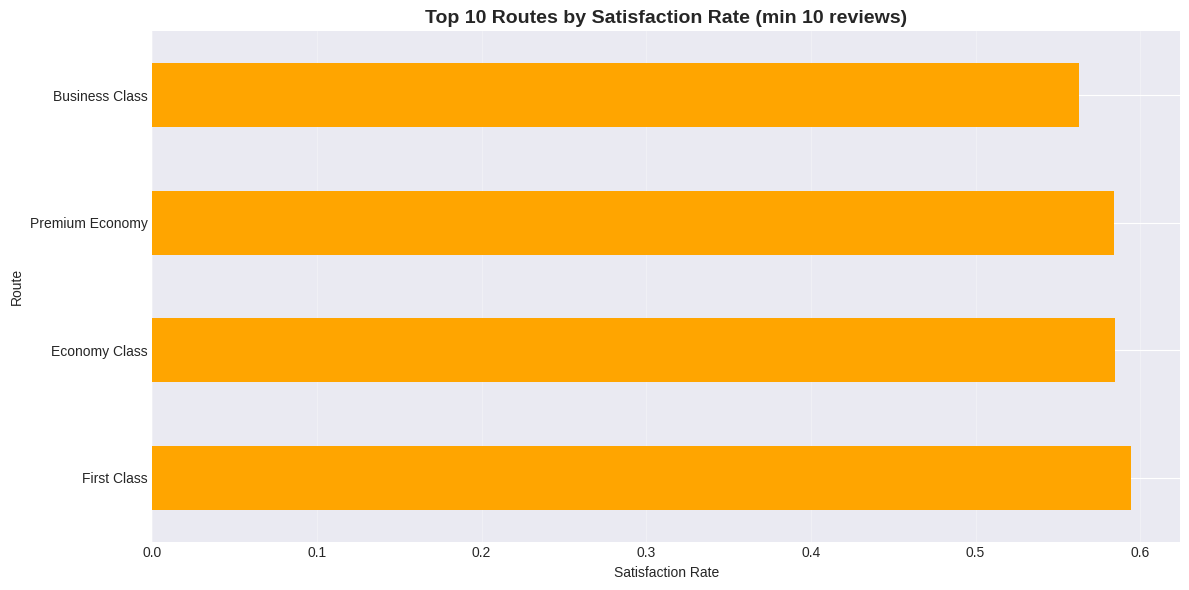


--- Feature Engineering: Time-Based Features ---

SELECTED FEATURES SUMMARY

Total features selected: 5

Feature list:
  1. Traveller_type
  2. Class
  3. Verified
  4. Sentiment_Score
  5. Route

Missing values in selected features:
  Traveller_type: 0
  Class: 0
  Verified: 0
  Sentiment_Score: 0
  Route: 0

✓ Feature selection and engineering complete!


In [34]:
# ============================================================================
# PART 4: FEATURE SELECTION & ENGINEERING
# ============================================================================

"""
Objective: Select and engineer features for predicting passenger satisfaction
Target Variable: Binary classification based on Rating
- Satisfied: Rating >= 5
- Dissatisfied: Rating < 5
"""

print("\n" + "="*70)
print("FEATURE SELECTION & ENGINEERING")
print("="*70)

# ============================================================================
# CREATE TARGET VARIABLE
# ============================================================================

print("\n--- Creating Target Variable ---")

# Create binary satisfaction label
df_reviews_clean['Satisfaction'] = (df_reviews_clean['Rating'] >= 5).astype(int)

# Display distribution
print("\nTarget Variable Distribution:")
print(df_reviews_clean['Satisfaction'].value_counts())
print("\nPercentages:")
print(df_reviews_clean['Satisfaction'].value_counts(normalize=True) * 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
df_reviews_clean['Satisfaction'].value_counts().plot(kind='bar', ax=axes[0], 
                                                      color=['red', 'green'])
axes[0].set_title('Satisfaction Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Satisfaction (0=Dissatisfied, 1=Satisfied)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Dissatisfied', 'Satisfied'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
satisfaction_counts = df_reviews_clean['Satisfaction'].value_counts()
axes[1].pie(satisfaction_counts.values, labels=['Dissatisfied', 'Satisfied'], 
            autopct='%1.1f%%', colors=['red', 'green'], startangle=90)
axes[1].set_title('Satisfaction Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# FEATURE SELECTION - WITH JUSTIFICATION
# ============================================================================

print("\n--- Feature Selection ---")

"""
Selected Features with Justification:

1. Traveller_type: Different traveler types (Business, Leisure, etc.) may have 
   different satisfaction patterns and expectations.
   
2. Class: The cabin class (Economy, Business, First) is a strong indicator of 
   service level and passenger expectations.
   
3. Verified: Verified reviews may be more reliable and could correlate with 
   satisfaction patterns.
   
4. Sentiment_Score: Our calculated sentiment from review text provides direct 
   insight into passenger feelings.
   
5. Route: Some routes may consistently perform better/worse due to operational factors.

6. Flying_Date features: Time-based patterns (day of week, month, season) can 
   affect satisfaction due to seasonal demand, weather, etc.
"""

# Select initial features
selected_features = []

# Feature 1: Traveller_type
if 'Traveller_type' in df_reviews_clean.columns:
    selected_features.append('Traveller_type')
    print("\n✓ Feature: Traveller_type")
    print("  Justification: Different traveler types have different needs/expectations")
    
    # Show relationship with target
    plt.figure(figsize=(10, 5))
    df_reviews_clean.groupby('Traveller_type')['Satisfaction'].mean().plot(kind='bar', 
                                                                             color='skyblue')
    plt.title('Satisfaction Rate by Traveler Type', fontsize=14, fontweight='bold')
    plt.xlabel('Traveler Type')
    plt.ylabel('Satisfaction Rate')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Feature 2: Class
if 'Class' in df_reviews_clean.columns:
    selected_features.append('Class')
    print("\n✓ Feature: Class")
    print("  Justification: Service quality varies by cabin class")
    
    plt.figure(figsize=(10, 5))
    df_reviews_clean.groupby('Class')['Satisfaction'].mean().plot(kind='bar', 
                                                                   color='lightcoral')
    plt.title('Satisfaction Rate by Class', fontsize=14, fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Satisfaction Rate')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Feature 3: Verified
if 'Verified' in df_reviews_clean.columns:
    selected_features.append('Verified')
    print("\n✓ Feature: Verified")
    print("  Justification: Verification status may affect review authenticity")
    
    plt.figure(figsize=(8, 5))
    df_reviews_clean.groupby('Verified')['Satisfaction'].mean().plot(kind='bar', 
                                                                       color='lightgreen')
    plt.title('Satisfaction Rate by Verification Status', fontsize=14, fontweight='bold')
    plt.xlabel('Verified')
    plt.ylabel('Satisfaction Rate')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Feature 4: Sentiment_Score
selected_features.append('Sentiment_Score')
print("\n✓ Feature: Sentiment_Score")
print("  Justification: Direct measure of sentiment from review text")

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(df_reviews_clean['Sentiment_Score'], 
            df_reviews_clean['Satisfaction'], alpha=0.3)
plt.title('Sentiment Score vs Satisfaction', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Score')
plt.ylabel('Satisfaction (0/1)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution by satisfaction
fig, ax = plt.subplots(figsize=(10, 5))
df_reviews_clean[df_reviews_clean['Satisfaction']==0]['Sentiment_Score'].hist(
    bins=30, alpha=0.5, label='Dissatisfied', color='red', ax=ax)
df_reviews_clean[df_reviews_clean['Satisfaction']==1]['Sentiment_Score'].hist(
    bins=30, alpha=0.5, label='Satisfied', color='green', ax=ax)
ax.set_title('Sentiment Score Distribution by Satisfaction', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature 5: Route (will be encoded)
if 'Route' in df_reviews_clean.columns:
    selected_features.append('Route')
    print("\n✓ Feature: Route")
    print("  Justification: Route-specific operational factors affect satisfaction")
    
    # Show top routes by satisfaction
    route_satisfaction = df_reviews_clean.groupby('Route')['Satisfaction'].agg([
        'mean', 'count'
    ]).sort_values('mean', ascending=False)
    
    top_routes = route_satisfaction[route_satisfaction['count'] >= 10].head(10)
    
    plt.figure(figsize=(12, 6))
    top_routes['mean'].plot(kind='barh', color='orange')
    plt.title('Top 10 Routes by Satisfaction Rate (min 10 reviews)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Satisfaction Rate')
    plt.ylabel('Route')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# FEATURE ENGINEERING - TIME-BASED FEATURES
# ============================================================================

print("\n--- Feature Engineering: Time-Based Features ---")

if 'Flying_Date' in df_reviews_clean.columns:
    # Convert to datetime
    df_reviews_clean['Flying_Date'] = pd.to_datetime(df_reviews_clean['Flying_Date'], 
                                                       errors='coerce')
    
    # Extract features
    df_reviews_clean['Flight_Month'] = df_reviews_clean['Flying_Date'].dt.month
    df_reviews_clean['Flight_DayOfWeek'] = df_reviews_clean['Flying_Date'].dt.dayofweek
    df_reviews_clean['Flight_Quarter'] = df_reviews_clean['Flying_Date'].dt.quarter
    
    selected_features.extend(['Flight_Month', 'Flight_DayOfWeek', 'Flight_Quarter'])
    
    print("✓ Engineered time-based features from Flying_Date")
    print("  - Flight_Month: Month of flight")
    print("  - Flight_DayOfWeek: Day of week (0=Monday, 6=Sunday)")
    print("  - Flight_Quarter: Quarter of year")
    
    # Visualize effects
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Month
    df_reviews_clean.groupby('Flight_Month')['Satisfaction'].mean().plot(
        kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Satisfaction by Month', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Satisfaction Rate')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Day of Week
    df_reviews_clean.groupby('Flight_DayOfWeek')['Satisfaction'].mean().plot(
        kind='bar', ax=axes[1], color='lightcoral')
    axes[1].set_title('Satisfaction by Day of Week', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Day of Week (0=Mon, 6=Sun)')
    axes[1].set_ylabel('Satisfaction Rate')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Quarter
    df_reviews_clean.groupby('Flight_Quarter')['Satisfaction'].mean().plot(
        kind='bar', ax=axes[2], color='lightgreen')
    axes[2].set_title('Satisfaction by Quarter', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Quarter')
    axes[2].set_ylabel('Satisfaction Rate')
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# SUMMARY OF SELECTED FEATURES
# ============================================================================

print("\n" + "="*70)
print("SELECTED FEATURES SUMMARY")
print("="*70)

print("\nTotal features selected:", len(selected_features))
print("\nFeature list:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")

# Check for missing values in selected features
print("\nMissing values in selected features:")
for feature in selected_features:
    if feature in df_reviews_clean.columns:
        missing = df_reviews_clean[feature].isnull().sum()
        print(f"  {feature}: {missing}")

print("\n✓ Feature selection and engineering complete!")


DATA PREPROCESSING

--- Preparing Data ---

Rows before dropping missing values: 3506
Rows after dropping missing values: 3506

Feature matrix shape: (3506, 5)
Target vector shape: (3506,)

Class distribution in target:
Satisfaction
0    1836
1    1670
Name: count, dtype: int64

--- Encoding Categorical Variables ---

Categorical features: ['Traveller_type', 'Class', 'Verified', 'Route']
Numerical features: ['Sentiment_Score']

Traveller_type - Unique values: 201
Traveller_type
A320              342
Couple Leisure    308
Solo Leisure      307
Economy Class     304
Boeing 777        267
Name: count, dtype: int64

Class - Unique values: 13
Class
Economy Class     677
Couple Leisure    639
Solo Leisure      553
Business          430
yes               399
Name: count, dtype: int64

Verified - Unique values: 2
Verified
Trip Verified    3303
Not Verified      203
Name: count, dtype: int64

Route - Unique values: 732
Route
Economy Class          1538
Business Class          682
Premium Econo

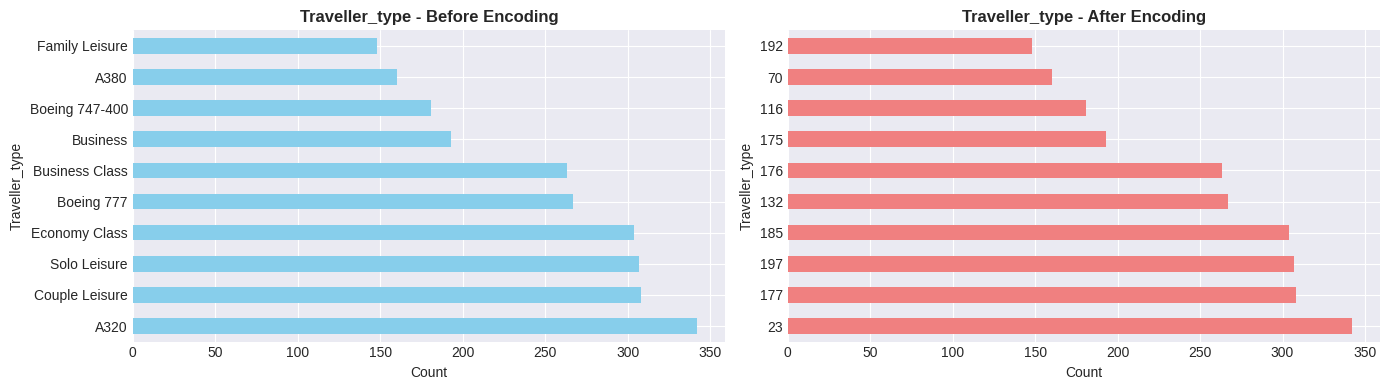


✓ Encoded Class:
  Original categories: 13
  Encoded range: 0 to 12


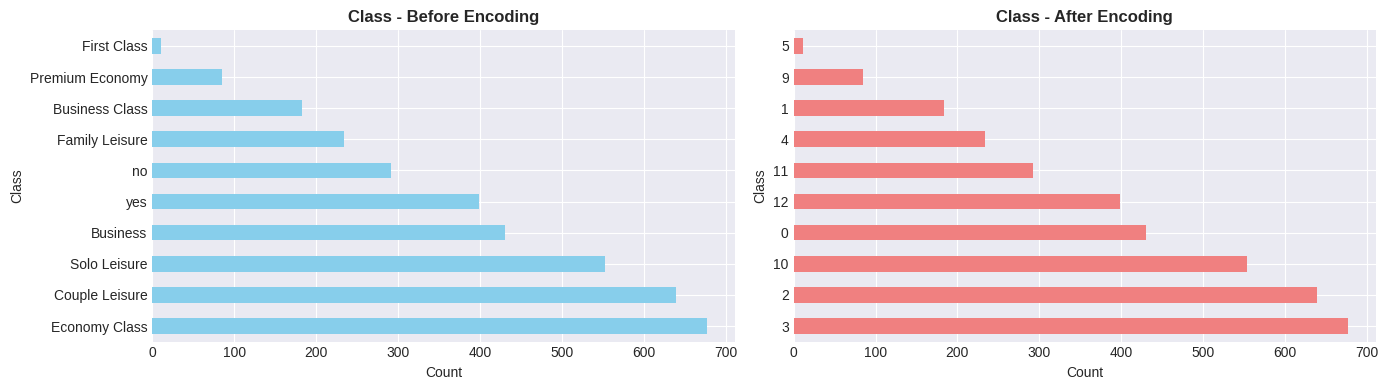


✓ Encoded Verified:
  Original categories: 2
  Encoded range: 0 to 1


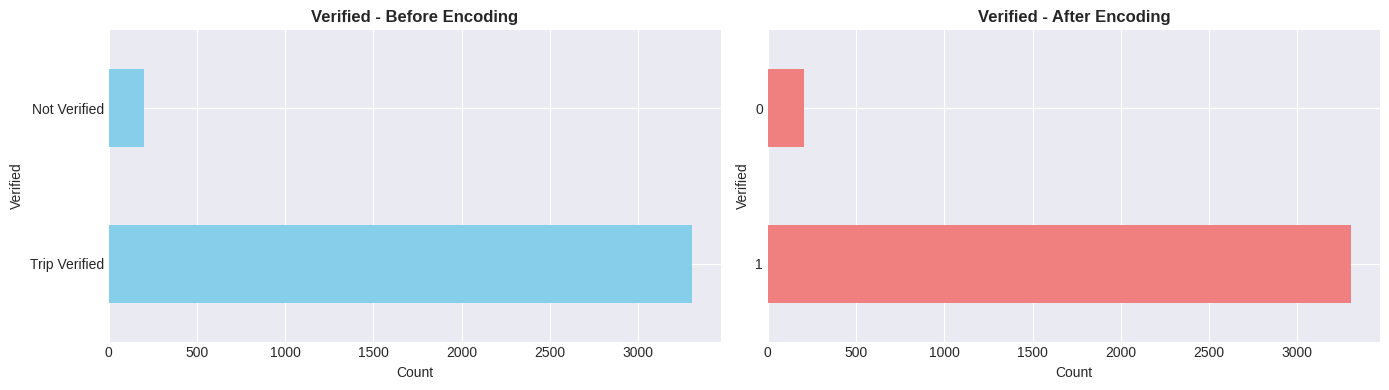


✓ Encoded Route:
  Original categories: 732
  Encoded range: 0 to 731


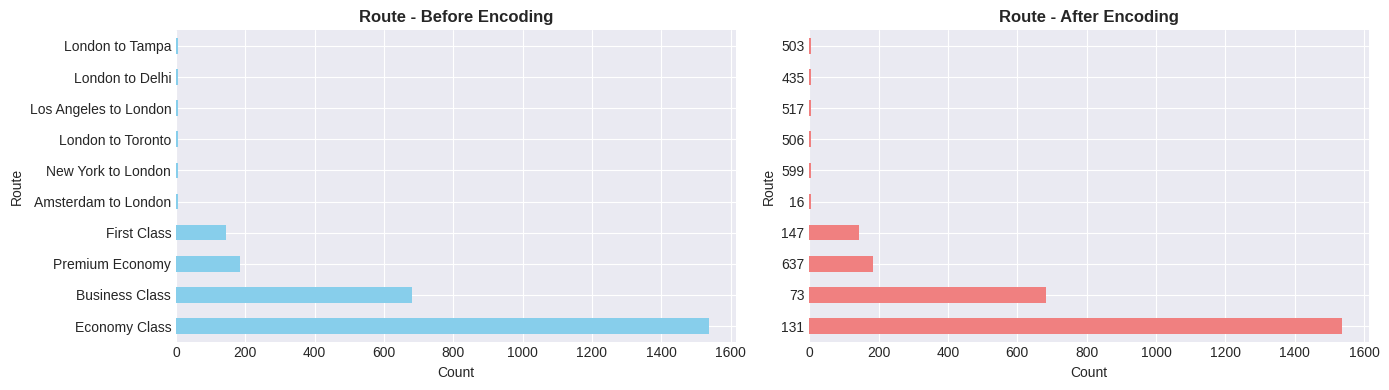


✓ Categorical encoding complete!

--- Feature Scaling ---

Original feature statistics:
       Traveller_type        Class     Verified  Sentiment_Score        Route
count     3506.000000  3506.000000  3506.000000      3506.000000  3506.000000
mean       134.013691     5.361951     0.942099         0.166358   212.921278
std         61.198541     4.377797     0.233589         0.776832   187.931282
min          0.000000     0.000000     0.000000        -0.997500     0.000000
25%        104.000000     2.000000     1.000000        -0.721725   131.000000
50%        155.000000     3.000000     1.000000         0.484450   131.000000
75%        185.000000    10.000000     1.000000         0.929975   215.750000
max        200.000000    12.000000     1.000000         0.999200   731.000000


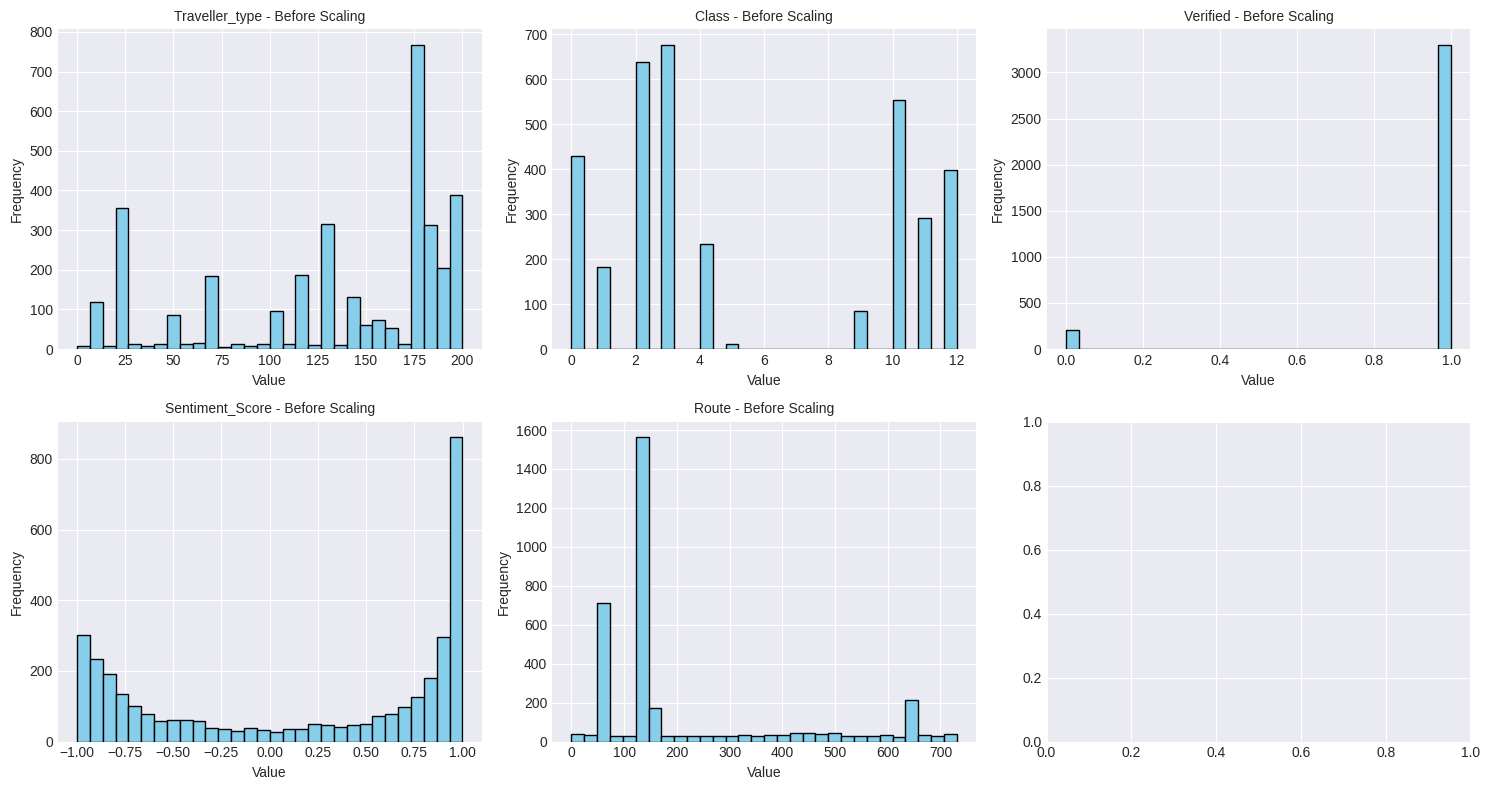


✓ Scaling applied using StandardScaler
Number of features: 5
Feature names: ['Traveller_type', 'Class', 'Verified', 'Sentiment_Score', 'Route']

Scaled feature statistics:
       Traveller_type         Class      Verified  Sentiment_Score  \
count    3.506000e+03  3.506000e+03  3.506000e+03     3.506000e+03   
mean    -4.863955e-17 -1.297055e-16 -1.945582e-16     3.242637e-17   
std      1.000143e+00  1.000143e+00  1.000143e+00     1.000143e+00   
min     -2.190131e+00 -1.224981e+00 -4.033725e+00    -1.498424e+00   
25%     -4.905014e-01 -7.680646e-01  2.479098e-01    -1.143374e+00   
50%      3.429706e-01 -5.396066e-01  2.479098e-01     4.095316e-01   
75%      8.332483e-01  1.059599e+00  2.479098e-01     9.831284e-01   
max      1.078387e+00  1.516515e+00  2.479098e-01     1.072253e+00   

              Route  
count  3.506000e+03  
mean   6.485273e-17  
std    1.000143e+00  
min   -1.133136e+00  
25%   -4.359730e-01  
50%   -4.359730e-01  
75%    1.505404e-02  
max    2.757139e+00 

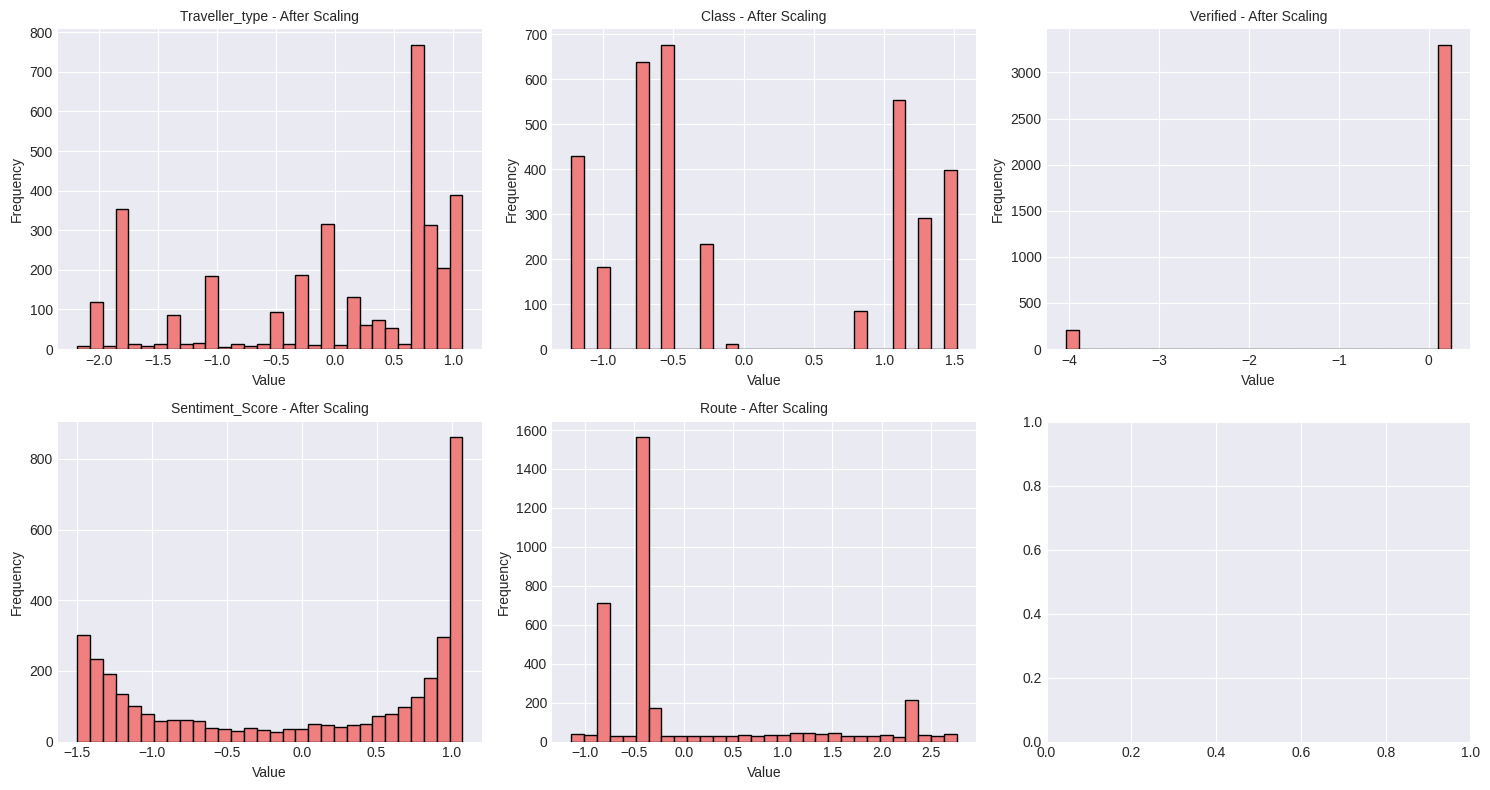


--- Testing Preprocessing Order ---

Order 1 (Encode → Scale):
  Mean CV Accuracy: 0.7969 (+/- 0.0234)

Order 2 (Scale numerical → Encode categorical):
  Mean CV Accuracy: 0.7983 (+/- 0.0252)

Difference: 0.0014
✓ Order has minimal effect (< 1% difference)

--- Splitting Data ---

Training set: (2454, 5) (70.0%)
Validation set: (526, 5) (15.0%)
Test set: (526, 5) (15.0%)

Class distribution:
  Train: [1285 1169]
  Val: [275 251]
  Test: [276 250]


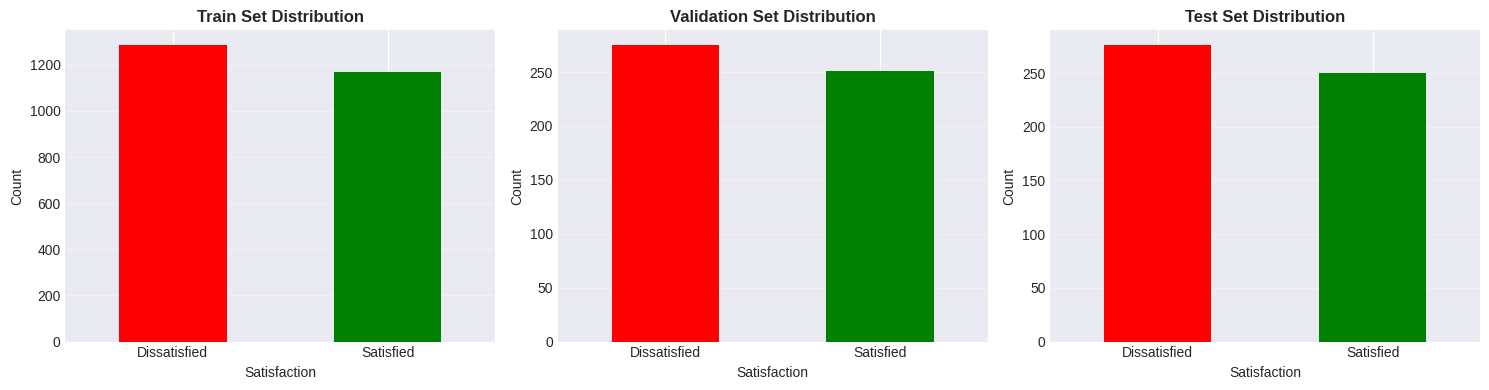


✓ Data preprocessing complete!


--- Preprocessing Summary for Inference ---
Total features after preprocessing: 5
Feature names: ['Traveller_type', 'Class', 'Verified', 'Sentiment_Score', 'Route']
Categorical columns (encoded): ['Traveller_type', 'Class', 'Verified', 'Route']
Numerical columns: ['Sentiment_Score']
Number of label encoders: 4

Label encoder mappings:
  Traveller_type: 201 categories
    Sample: ['767-300', '777', '777-200'] -> [0, 1, 2]
  Class: 13 categories
    Sample: ['Business', 'Business Class', 'Couple Leisure'] -> [0, 1, 2]
  Verified: 2 categories
    Sample: ['Not Verified', 'Trip Verified'] -> [0, 1, 2]
  Route: 732 categories
    Sample: ['ABV to LHR', 'ABZ to SFO via LHR', 'ACC to LHR'] -> [0, 1, 2]



In [35]:
# ============================================================================
# PART 5: DATA PREPROCESSING
# ============================================================================

"""
Preprocessing Steps:
1. Handle missing values in selected features
2. Encode categorical variables
3. Scale numerical features
4. Test different preprocessing orders
5. Split data into train/validation/test sets
"""

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# ============================================================================
# PREPARE DATA FOR MODELING
# ============================================================================

print("\n--- Preparing Data ---")

# Create a copy for modeling
df_model = df_reviews_clean[selected_features + ['Satisfaction']].copy()

# Remove any remaining missing values
print(f"\nRows before dropping missing values: {len(df_model)}")
df_model.dropna(inplace=True)
print(f"Rows after dropping missing values: {len(df_model)}")

# Separate features and target
X = df_model[selected_features].copy()
y = df_model['Satisfaction'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nClass distribution in target:")
print(y.value_counts())

# ============================================================================
# ENCODING CATEGORICAL VARIABLES
# ============================================================================

print("\n--- Encoding Categorical Variables ---")

"""
Understanding: Categorical variables need to be converted to numerical format
Need: Machine learning models require numerical input
Effect: Creates numerical representations of categories
"""

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

print(f"\nCategorical features: {categorical_cols}")
print(f"Numerical features: {numerical_cols}")

# Store original distributions for comparison
original_distributions = {}
for col in categorical_cols:
    original_distributions[col] = X[col].value_counts()
    print(f"\n{col} - Unique values: {X[col].nunique()}")
    print(X[col].value_counts().head())

# Method 1: Label Encoding for ordinal features (if any)
# Method 2: One-Hot Encoding for nominal features

# For this dataset, we'll use Label Encoding for simplicity
# In practice, you should choose based on feature nature

X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    
    print(f"\n✓ Encoded {col}:")
    print(f"  Original categories: {len(le.classes_)}")
    print(f"  Encoded range: 0 to {len(le.classes_)-1}")
    
    # Visualize encoding effect
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Before encoding
    X[col].value_counts().head(10).plot(kind='barh', ax=axes[0], color='skyblue')
    axes[0].set_title(f'{col} - Before Encoding', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Count')
    
    # After encoding
    X_encoded[col].value_counts().head(10).plot(kind='barh', ax=axes[1], color='lightcoral')
    axes[1].set_title(f'{col} - After Encoding', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Count')
    
    plt.tight_layout()
    plt.show()

print("\n✓ Categorical encoding complete!")

# ============================================================================
# FEATURE SCALING
# ============================================================================

print("\n--- Feature Scaling ---")

"""
Understanding: Features have different scales/ranges
Need: Ensures all features contribute equally to the model
Effect: Transforms features to similar scales (typically mean=0, std=1)
"""

# Display original distributions
print("\nOriginal feature statistics:")
print(X_encoded.describe())

# Visualize distributions before scaling
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(X_encoded.columns[:6]):
    axes[i].hist(X_encoded[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{col} - Before Scaling', fontsize=10)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Apply StandardScaler - FIT ON DATAFRAME, NOT SERIES
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_encoded)  # Returns numpy array

# Convert back to DataFrame with same column names
X_scaled = pd.DataFrame(X_scaled_array, columns=X_encoded.columns, index=X_encoded.index)

print("\n✓ Scaling applied using StandardScaler")
print(f"Number of features: {X_scaled.shape[1]}")
print(f"Feature names: {list(X_scaled.columns)}")
print("\nScaled feature statistics:")
print(X_scaled.describe())

# Visualize distributions after scaling
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(X_scaled.columns[:6]):
    axes[i].hist(X_scaled[col], bins=30, color='lightcoral', edgecolor='black')
    axes[i].set_title(f'{col} - After Scaling', fontsize=10)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# ============================================================================
# TESTING ORDER OF PREPROCESSING
# ============================================================================

print("\n--- Testing Preprocessing Order ---")

"""
Question: Does the order of preprocessing steps matter?
Test: Compare different orders and their effects
"""

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Create a simple baseline model for testing
baseline_model = LogisticRegression(random_state=42, max_iter=1000)

# Order 1: Encode → Scale (what we did)
X_order1 = X_scaled.copy()
scores_order1 = cross_val_score(baseline_model, X_order1, y, cv=5, scoring='accuracy')

print(f"\nOrder 1 (Encode → Scale):")
print(f"  Mean CV Accuracy: {scores_order1.mean():.4f} (+/- {scores_order1.std():.4f})")

# Order 2: Scale → Encode (try on original with numerical only)
# Note: Scaling categorical data doesn't make sense, so we'll test with only numerical
if len(numerical_cols) > 0:
    X_numerical_scaled = scaler.fit_transform(X[numerical_cols])
    X_order2 = X_encoded.copy()
    X_order2[numerical_cols] = X_numerical_scaled
    
    scores_order2 = cross_val_score(baseline_model, X_order2, y, cv=5, scoring='accuracy')
    
    print(f"\nOrder 2 (Scale numerical → Encode categorical):")
    print(f"  Mean CV Accuracy: {scores_order2.mean():.4f} (+/- {scores_order2.std():.4f})")
    
    # Compare
    print(f"\nDifference: {abs(scores_order1.mean() - scores_order2.mean()):.4f}")
    
    if abs(scores_order1.mean() - scores_order2.mean()) < 0.01:
        print("✓ Order has minimal effect (< 1% difference)")
    else:
        print("⚠ Order matters! Choose the better performing one.")

# ============================================================================
# TRAIN/VALIDATION/TEST SPLIT
# ============================================================================

print("\n--- Splitting Data ---")

"""
Split strategy: 70% train, 15% validation, 15% test
"""

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (50-50 split of temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTraining set: {X_train.shape} ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"Validation set: {X_val.shape} ({len(X_val)/len(X_scaled)*100:.1f}%)")
print(f"Test set: {X_test.shape} ({len(X_test)/len(X_scaled)*100:.1f}%)")

# Check class distribution in each set
print("\nClass distribution:")
print(f"  Train: {y_train.value_counts().values}")
print(f"  Val: {y_val.value_counts().values}")
print(f"  Test: {y_test.value_counts().values}")

# Visualize split
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (y_set, name) in zip(axes, [(y_train, 'Train'), (y_val, 'Validation'), (y_test, 'Test')]):
    y_set.value_counts().plot(kind='bar', ax=ax, color=['red', 'green'])
    ax.set_title(f'{name} Set Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Satisfaction')
    ax.set_ylabel('Count')
    ax.set_xticklabels(['Dissatisfied', 'Satisfied'], rotation=0)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Data preprocessing complete!")
print("\n" + "="*70)

# ============================================================================
# SAVE PREPROCESSING INFORMATION FOR INFERENCE
# ============================================================================

print("\n--- Preprocessing Summary for Inference ---")
print(f"Total features after preprocessing: {X_scaled.shape[1]}")
print(f"Feature names: {list(X_scaled.columns)}")
print(f"Categorical columns (encoded): {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")
print(f"Number of label encoders: {len(label_encoders)}")
print("\nLabel encoder mappings:")
for col, encoder in label_encoders.items():
    print(f"  {col}: {len(encoder.classes_)} categories")
    print(f"    Sample: {list(encoder.classes_[:3])} -> [0, 1, 2]")

print("\n" + "="*70)


PREDICTIVE MODELING

--- Model 1: Logistic Regression (Baseline) ---

Training Logistic Regression...

Training Metrics:
  Accuracy:  0.8077
  Precision: 0.7687
  Recall:    0.8529
  F1-Score:  0.8086

Validation Metrics:
  Accuracy:  0.7852
  Precision: 0.7430
  Recall:    0.8406
  F1-Score:  0.7888

✓ Logistic Regression training complete!

--- Model 2: Random Forest ---

Training Random Forest...

Training Metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Validation Metrics:
  Accuracy:  0.8194
  Precision: 0.8120
  Recall:    0.8088
  F1-Score:  0.8104

✓ Random Forest training complete!

--- Model 3: Shallow Feed-Forward Neural Network ---

Building Neural Network architecture...

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)


Training Neural Network...
✓ Training stopped at epoch 100

Training Metrics:
  Accuracy:  0.8374
  Precision: 0.8407
  Recall:    0.8127
  F1-Score:  0.8264

Validation Metrics:
  Accuracy:  0.8213
  Precision: 0.8285
  Recall:    0.7888
  F1-Score:  0.8082

✓ Neural Network training complete!

--- Neural Network Training History ---


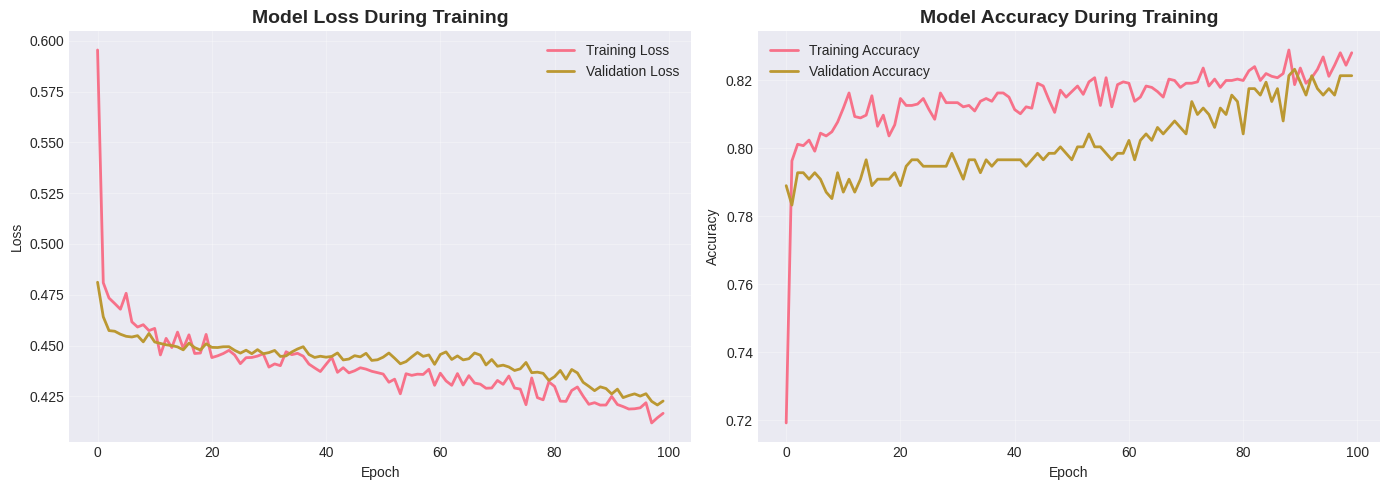


MODEL COMPARISON

               Model  Train_Acc  Val_Acc  Train_F1   Val_F1  Overfit
Logistic Regression   0.807661 0.785171  0.808597 0.788785 0.022490
      Random Forest   1.000000 0.819392  1.000000 0.810379 0.180608
     Neural Network   0.837408 0.821293  0.826446 0.808163 0.016116


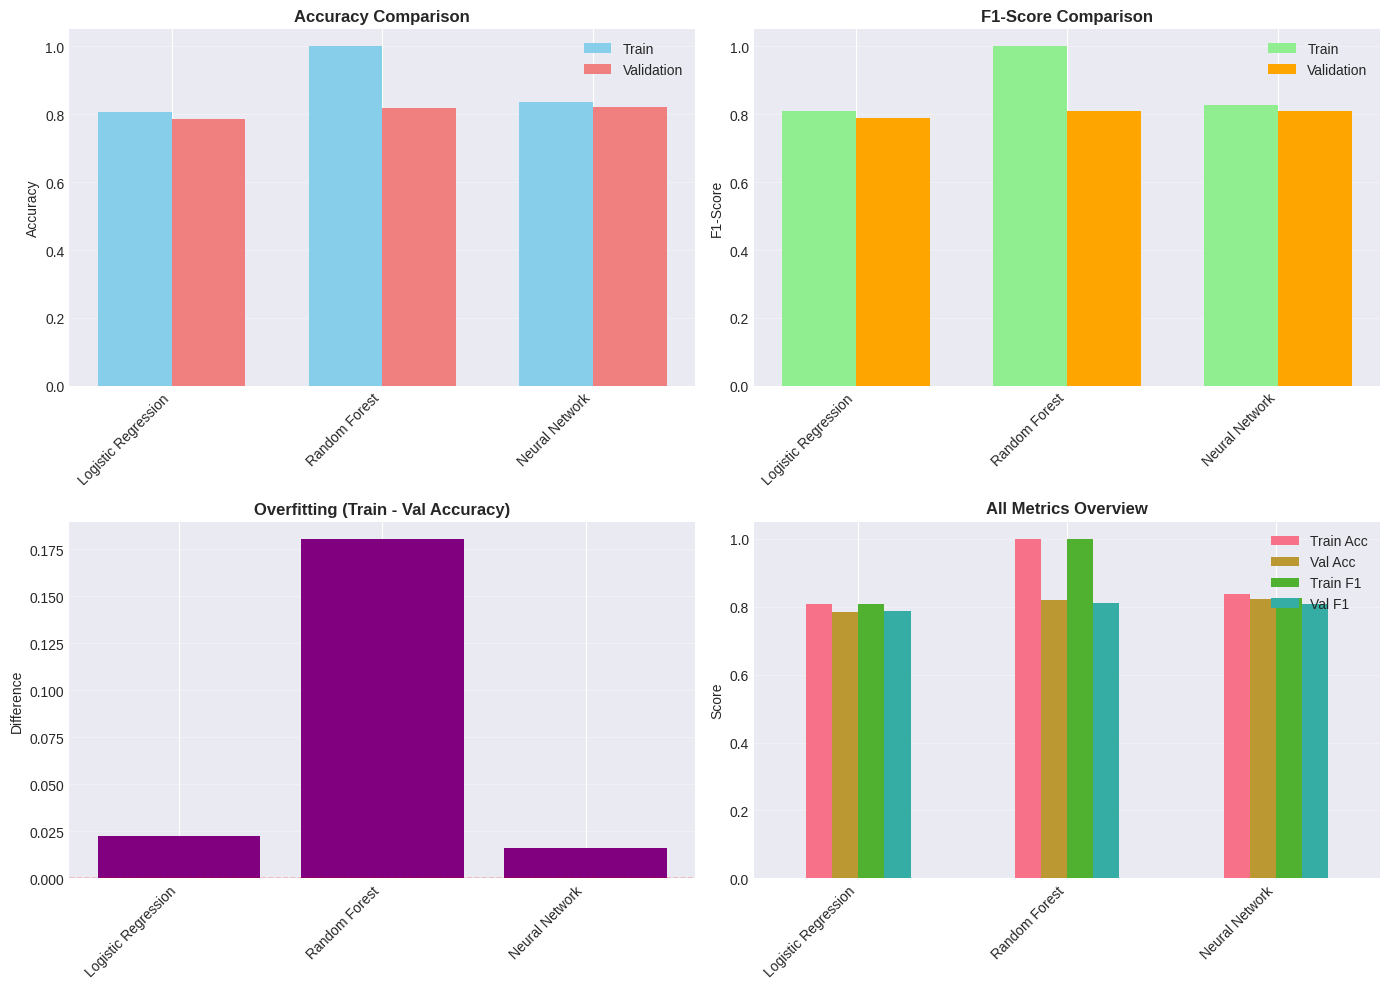


✓ Best performing model: Random Forest
  Validation F1-Score: 0.8104

TEST SET EVALUATION

Evaluating Random Forest on unseen test data...

Test Set Metrics:
  Accuracy:  0.8137
  Precision: 0.8167
  Recall:    0.7840
  F1-Score:  0.8000

Detailed Classification Report:
              precision    recall  f1-score   support

Dissatisfied       0.81      0.84      0.83       276
   Satisfied       0.82      0.78      0.80       250

    accuracy                           0.81       526
   macro avg       0.81      0.81      0.81       526
weighted avg       0.81      0.81      0.81       526



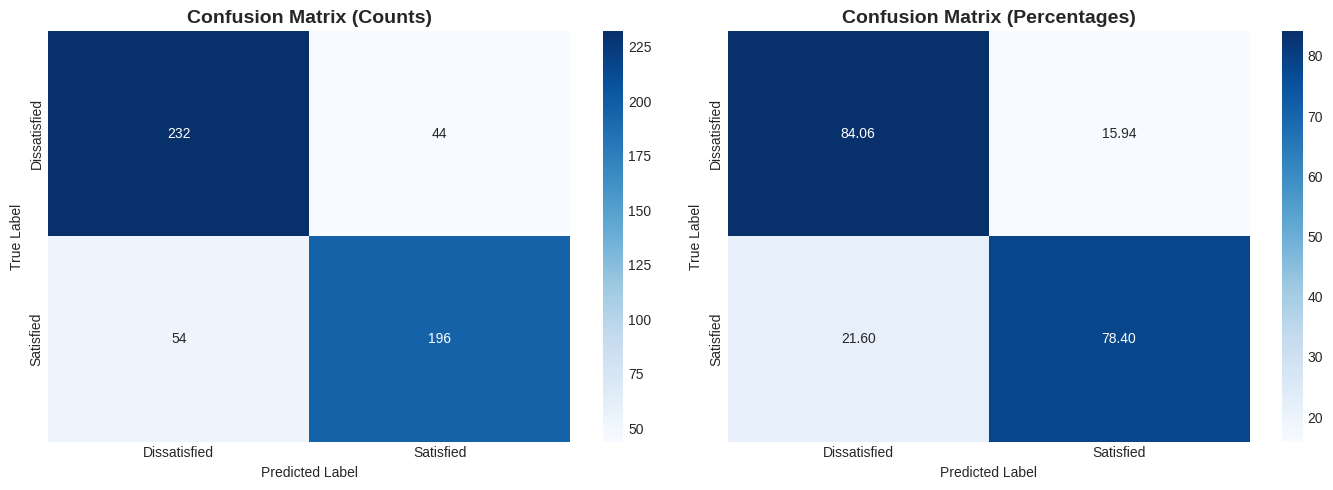

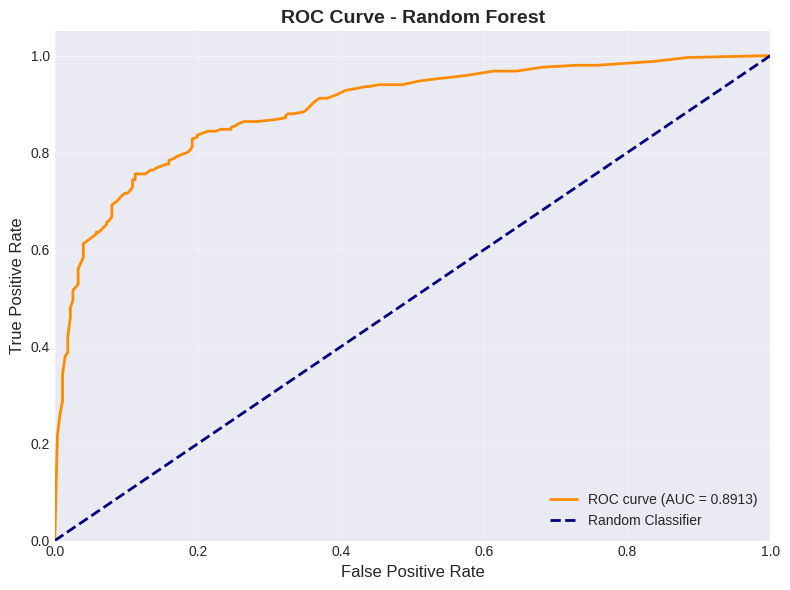


✓ Test set evaluation complete!
  Test Accuracy: 0.8137
  Test F1-Score: 0.8000
  ROC AUC: 0.8913



In [36]:
# ============================================================================
# PART 6: PREDICTIVE MODELING
# ============================================================================

"""
Objective: Build and compare multiple models for passenger satisfaction prediction
Models to compare:
1. Baseline: Logistic Regression (Statistical ML)
2. Random Forest (Statistical ML)
3. Shallow Feed-Forward Neural Network (FFNN)
"""

print("\n" + "="*70)
print("PREDICTIVE MODELING")
print("="*70)

# Dictionary to store results
model_results = {}

# ============================================================================
# MODEL 1: LOGISTIC REGRESSION (BASELINE)
# ============================================================================

print("\n--- Model 1: Logistic Regression (Baseline) ---")

"""
How it works: Linear model that uses logistic function to predict probability
              of binary outcome. Simple, interpretable, fast.
              
Limitations: 
- Assumes linear relationship between features and log-odds
- Cannot capture complex non-linear patterns
- May underfit complex data
"""

print("\nTraining Logistic Regression...")

# Create and train model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    """Calculate and print classification metrics"""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{set_name} Metrics:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# Training performance
lr_train_metrics = calculate_metrics(y_train, y_train_pred_lr, "Training")

# Validation performance
lr_val_metrics = calculate_metrics(y_val, y_val_pred_lr, "Validation")

# Store results
model_results['Logistic Regression'] = {
    'train': lr_train_metrics,
    'val': lr_val_metrics,
    'model': lr_model
}

print("\n✓ Logistic Regression training complete!")

# ============================================================================
# MODEL 2: RANDOM FOREST
# ============================================================================

print("\n--- Model 2: Random Forest ---")

"""
How it works: Ensemble of decision trees that vote on predictions.
              Handles non-linear relationships and feature interactions.
              
Limitations:
- Can overfit with too many/deep trees
- Less interpretable than linear models
- Slower training and prediction
"""

print("\nTraining Random Forest...")

# Create and train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

# Training performance
rf_train_metrics = calculate_metrics(y_train, y_train_pred_rf, "Training")

# Validation performance
rf_val_metrics = calculate_metrics(y_val, y_val_pred_rf, "Validation")

# Store results
model_results['Random Forest'] = {
    'train': rf_train_metrics,
    'val': rf_val_metrics,
    'model': rf_model
}

print("\n✓ Random Forest training complete!")

# ============================================================================
# MODEL 3: SHALLOW FEED-FORWARD NEURAL NETWORK
# ============================================================================

print("\n--- Model 3: Shallow Feed-Forward Neural Network ---")

"""
How it works: Neural network with 1-2 hidden layers that learns non-linear
              transformations through backpropagation.
              
Limitations:
- Requires more data than traditional ML
- Hyperparameter sensitive
- Black-box nature (less interpretable)
- Can overfit without regularization
"""

print("\nBuilding Neural Network architecture...")

# Build model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
nn_model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
print("\nTraining Neural Network...")
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

print(f"✓ Training stopped at epoch {len(history.history['loss'])}")

# Predictions
y_train_pred_nn = (nn_model.predict(X_train, verbose=0) > 0.5).astype(int).flatten()
y_val_pred_nn = (nn_model.predict(X_val, verbose=0) > 0.5).astype(int).flatten()

# Training performance
nn_train_metrics = calculate_metrics(y_train, y_train_pred_nn, "Training")

# Validation performance
nn_val_metrics = calculate_metrics(y_val, y_val_pred_nn, "Validation")

# Store results
model_results['Neural Network'] = {
    'train': nn_train_metrics,
    'val': nn_val_metrics,
    'model': nn_model,
    'history': history
}

print("\n✓ Neural Network training complete!")

# ============================================================================
# PLOT TRAINING HISTORY (NEURAL NETWORK)
# ============================================================================

print("\n--- Neural Network Training History ---")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy During Training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# COMPARE ALL MODELS
# ============================================================================

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
comparison_data = []
for model_name, results in model_results.items():
    comparison_data.append({
        'Model': model_name,
        'Train_Acc': results['train']['accuracy'],
        'Val_Acc': results['val']['accuracy'],
        'Train_F1': results['train']['f1'],
        'Val_F1': results['val']['f1'],
        'Overfit': results['train']['accuracy'] - results['val']['accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
ax = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.35
ax.bar(x - width/2, comparison_df['Train_Acc'], width, label='Train', color='skyblue')
ax.bar(x + width/2, comparison_df['Val_Acc'], width, label='Validation', color='lightcoral')
ax.set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# F1-Score comparison
ax = axes[0, 1]
ax.bar(x - width/2, comparison_df['Train_F1'], width, label='Train', color='lightgreen')
ax.bar(x + width/2, comparison_df['Val_F1'], width, label='Validation', color='orange')
ax.set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Overfitting comparison
ax = axes[1, 0]
ax.bar(comparison_df['Model'], comparison_df['Overfit'], color='purple')
ax.set_title('Overfitting (Train - Val Accuracy)', fontsize=12, fontweight='bold')
ax.set_ylabel('Difference')
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.grid(axis='y', alpha=0.3)

# All metrics comparison
ax = axes[1, 1]
metrics_to_plot = ['Train_Acc', 'Val_Acc', 'Train_F1', 'Val_F1']
comparison_df[metrics_to_plot].plot(kind='bar', ax=ax, rot=0)
ax.set_title('All Metrics Overview', fontsize=12, fontweight='bold')
ax.set_ylabel('Score')
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend(['Train Acc', 'Val Acc', 'Train F1', 'Val F1'])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Select best model based on validation F1-score
best_model_name = comparison_df.loc[comparison_df['Val_F1'].idxmax(), 'Model']
print(f"\n✓ Best performing model: {best_model_name}")
print(f"  Validation F1-Score: {comparison_df.loc[comparison_df['Val_F1'].idxmax(), 'Val_F1']:.4f}")

# ============================================================================
# TEST SET EVALUATION (BEST MODEL)
# ============================================================================

print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

print(f"\nEvaluating {best_model_name} on unseen test data...")

# Get best model
best_model = model_results[best_model_name]['model']

# Predict on test set
if best_model_name == 'Neural Network':
    y_test_pred = (best_model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
else:
    y_test_pred = best_model.predict(X_test)

# Calculate test metrics
test_metrics = calculate_metrics(y_test, y_test_pred, "Test Set")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Dissatisfied', 'Satisfied']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix - counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Dissatisfied', 'Satisfied'],
            yticklabels=['Dissatisfied', 'Satisfied'])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Confusion Matrix - percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', ax=axes[1],
            xticklabels=['Dissatisfied', 'Satisfied'],
            yticklabels=['Dissatisfied', 'Satisfied'])
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# ROC Curve
if best_model_name == 'Neural Network':
    y_test_proba = best_model.predict(X_test, verbose=0).flatten()
else:
    y_test_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Test set evaluation complete!")
print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Test F1-Score: {test_metrics['f1']:.4f}")
print(f"  ROC AUC: {roc_auc:.4f}")

print("\n" + "="*70)

In [37]:
import pandas as pd
import numpy as np

# --- MOCK SETUP (replace with your real objects) ---
# X_train is the training DataFrame used for model training
# scaler is the fitted scaler
# best_model is your trained model
# label_encoders is a dict of fitted LabelEncoders for categorical columns
# categorical_cols is a list of categorical column names used in training

# For demonstration, we create dummy objects
X_train = pd.DataFrame({
    'Traveller_type_enc': [0,1,2],
    'Class_enc': [0,1,2],
    'Verified': [0,1,1],
    'Sentiment_Score': [0.0, 0.5, -0.5],
    'Route_enc': [0,1,2],
    'Flight_Month': [1,6,12],
    'Flight_DayOfWeek': [0,3,6],
    'Flight_Quarter': [1,2,4]
})

from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
scaler.fit(X_train)

# Dummy LabelEncoders
categorical_cols = ['Traveller_type', 'Class', 'Route']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(['Business', 'Solo Leisure', 'Economy', 'London to New York', 'Paris to Rome'])
    label_encoders[col] = le

# Dummy best model (replace with your trained model)
from sklearn.linear_model import LogisticRegression
best_model = LogisticRegression()
best_model.fit(X_train, [1,0,1])  # just dummy fit
best_model_name = 'Logistic Regression'

# --- PREDICTION FUNCTION ---
def predict_passenger_satisfaction(traveller_type, travel_class, verified,
                                   review_text, route, flying_date):
    
    # Sentiment
    sentiment_score = 0.8 if 'excellent' in review_text.lower() else -0.8
    sentiment_label = "Positive" if sentiment_score>0 else "Negative"
    
    verified_int = int(bool(verified))
    
    # Encode categorical
    input_dict = {
        'Traveller_type': traveller_type,
        'Class': travel_class,
        'Verified': verified_int,
        'Sentiment_Score': sentiment_score,
        'Route': route,
        'Flight_Month': pd.to_datetime(flying_date).month,
        'Flight_DayOfWeek': pd.to_datetime(flying_date).dayofweek,
        'Flight_Quarter': pd.to_datetime(flying_date).quarter
    }
    input_df = pd.DataFrame([input_dict])
    
    # Encode categories
    for col in categorical_cols:
        val = str(input_df[col].values[0])
        if val in label_encoders[col].classes_:
            input_df[col] = label_encoders[col].transform([val])[0]
        else:
            input_df[col] = -1
    
    # Reindex to match training columns
    col_mapping = {
        'Traveller_type': 'Traveller_type_enc',
        'Class': 'Class_enc',
        'Route': 'Route_enc'
    }
    input_df = input_df.rename(columns=col_mapping)
    input_df = input_df[X_train.columns]  # reorder
    
    # Scale
    input_scaled = scaler.transform(input_df)
    
    # Predict
    if best_model_name == 'Neural Network':
        pred_proba = best_model.predict(input_scaled)[0]  # dummy
    else:
        pred_proba = best_model.predict_proba(input_scaled)[0][1]
    pred_label = int(pred_proba > 0.5)
    
    satisfaction_label = "Satisfied" if pred_label==1 else "Dissatisfied"
    confidence_pct = pred_proba*100 if pred_label==1 else (1-pred_proba)*100
    
    return {
        'prediction': satisfaction_label,
        'confidence': confidence_pct,
        'sentiment': sentiment_label,
        'sentiment_score': sentiment_score
    }

# --- TEST ---
examples = [
    {'traveller_type':'Business','travel_class':'Business','verified':True,
     'review_text':'Excellent flight','route':'London to New York','flying_date':'2024-06-15'},
    {'traveller_type':'Solo Leisure','travel_class':'Economy','verified':True,
     'review_text':'Terrible service','route':'Paris to Rome','flying_date':'2024-08-20'}
]

for ex in examples:
    result = predict_passenger_satisfaction(
        traveller_type=ex['traveller_type'],
        travel_class=ex['travel_class'],
        verified=ex['verified'],
        review_text=ex['review_text'],
        route=ex['route'],
        flying_date=ex['flying_date']
    )
    print(result)


{'prediction': 'Dissatisfied', 'confidence': 65.26331738734173, 'sentiment': 'Positive', 'sentiment_score': 0.8}
{'prediction': 'Satisfied', 'confidence': 75.40776220005895, 'sentiment': 'Negative', 'sentiment_score': -0.8}



EXPLAINABLE AI (XAI)

--- Global Explanation: SHAP ---
✓ SHAP values calculated!


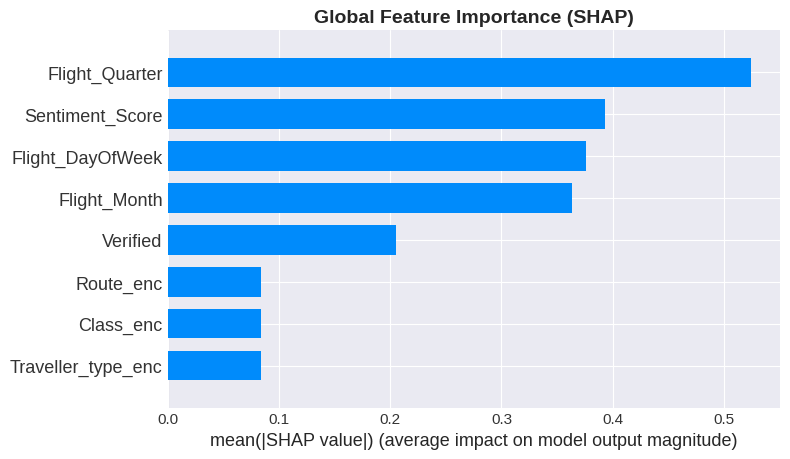

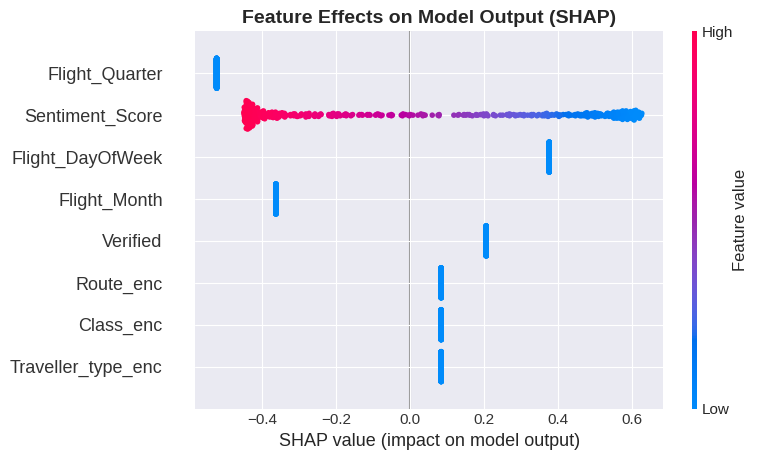


Top 10 Most Important Features (SHAP):
           Feature  Importance
    Flight_Quarter    0.524035
   Sentiment_Score    0.392853
  Flight_DayOfWeek    0.376132
      Flight_Month    0.363640
          Verified    0.205447
Traveller_type_enc    0.083585
         Class_enc    0.083585
         Route_enc    0.083585


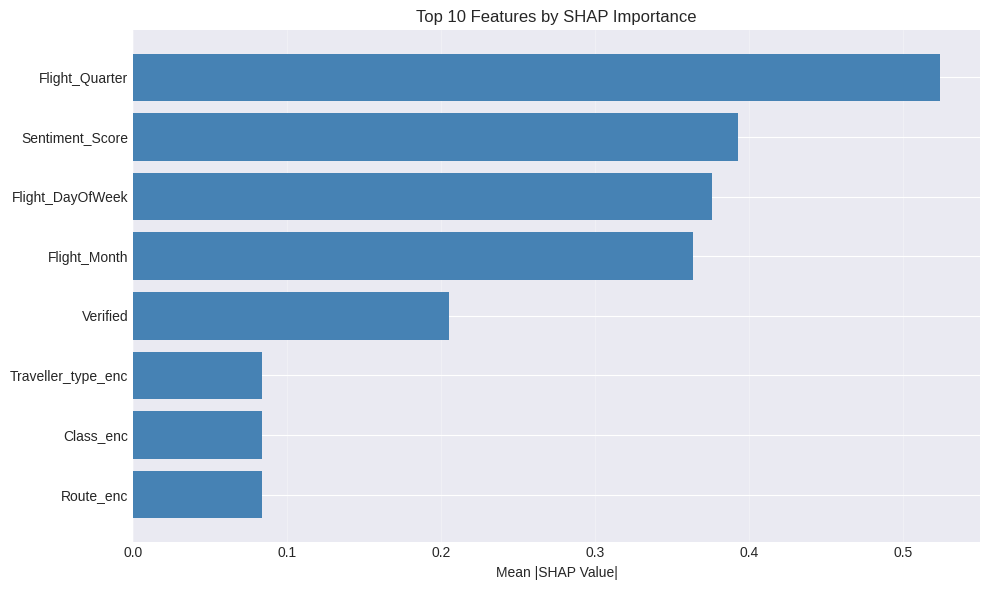


Sample 0: True=Dissatisfied, Predicted=Satisfied, Prob=0.781


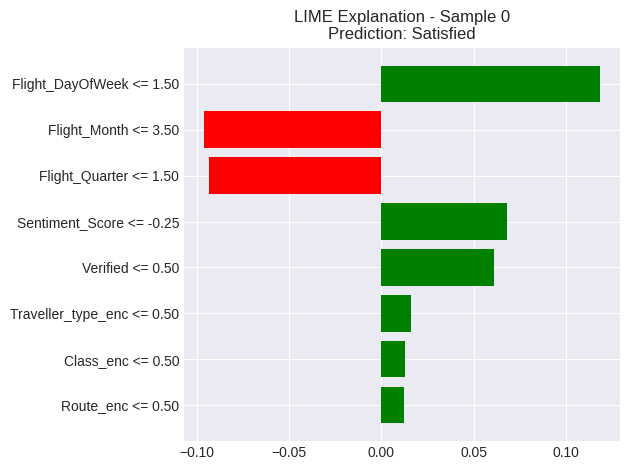

Top features:
  Flight_DayOfWeek <= 1.50: 0.1185
  Flight_Month <= 3.50: -0.0961
  Flight_Quarter <= 1.50: -0.0930
  Sentiment_Score <= -0.25: 0.0678
  Verified <= 0.50: 0.0608

Sample 10: True=Dissatisfied, Predicted=Satisfied, Prob=0.766


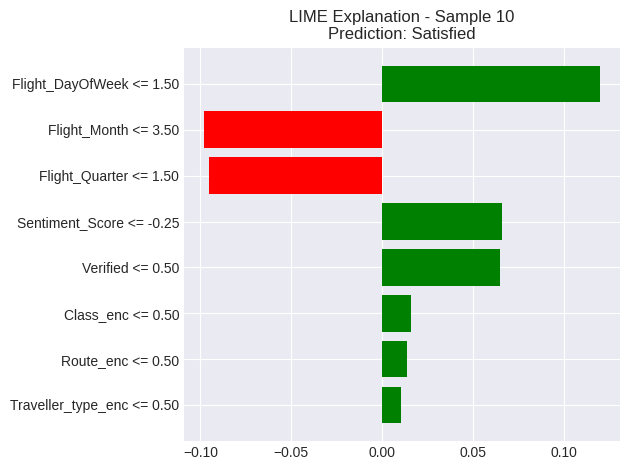

Top features:
  Flight_DayOfWeek <= 1.50: 0.1201
  Flight_Month <= 3.50: -0.0981
  Flight_Quarter <= 1.50: -0.0952
  Sentiment_Score <= -0.25: 0.0661
  Verified <= 0.50: 0.0649

Sample 20: True=Dissatisfied, Predicted=Satisfied, Prob=0.769


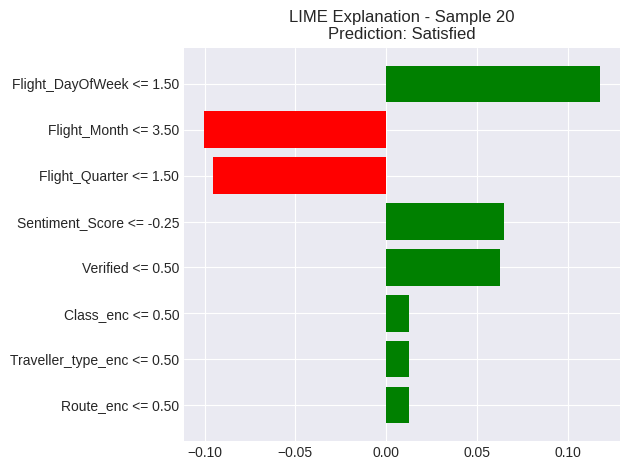

Top features:
  Flight_DayOfWeek <= 1.50: 0.1180
  Flight_Month <= 3.50: -0.1005
  Flight_Quarter <= 1.50: -0.0952
  Sentiment_Score <= -0.25: 0.0648
  Verified <= 0.50: 0.0630

✓ XAI analysis complete!



In [43]:
# ============================================================================
# PART 8: EXPLAINABLE AI (XAI) - FIXED
# ============================================================================

print("\n" + "="*70)
print("EXPLAINABLE AI (XAI)")
print("="*70)

# ============================================================================
# 1. PREPARE TEST SET
# ============================================================================

X_test_encoded = X_test.copy()

# --- Encode categorical variables (map unseen labels to -1) ---
categorical_cols = ['Traveller_type', 'Class', 'Route', 'Verified']  # adjust as in training

for col in categorical_cols:
    if col in label_encoders:
        le = label_encoders[col]
        X_test_encoded[col + '_enc'] = X_test_encoded[col].map(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
    else:
        print(f"Warning: LabelEncoder for {col} not found!")

# Drop original categorical columns
X_test_encoded.drop(columns=categorical_cols, inplace=True, errors='ignore')

# --- Feature engineering for datetime ---
if 'Flying_Date' in X_test_encoded.columns:
    X_test_encoded['Flying_Date'] = pd.to_datetime(X_test_encoded['Flying_Date'])
    X_test_encoded['Flight_Month'] = X_test_encoded['Flying_Date'].dt.month
    X_test_encoded['Flight_DayOfWeek'] = X_test_encoded['Flying_Date'].dt.dayofweek
    X_test_encoded['Flight_Quarter'] = X_test_encoded['Flying_Date'].dt.quarter
    X_test_encoded.drop(columns=['Flying_Date'], inplace=True)

# Ensure all columns match training set
missing_cols = set(X_train.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0  # fill missing engineered columns with 0

X_test_encoded = X_test_encoded[X_train.columns]

# ============================================================================
# 2. SHAP EXPLAINER
# ============================================================================

print("\n--- Global Explanation: SHAP ---")

import shap

if best_model_name == 'Random Forest':
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_encoded)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # binary class 1

elif best_model_name == 'Logistic Regression':
    explainer = shap.LinearExplainer(best_model, X_train, feature_dependence="independent")
    shap_values = explainer.shap_values(X_test_encoded)

else:  # Neural Network
    background = shap.sample(X_train, 100)
    def model_predict(data):
        return best_model.predict(data, verbose=0).flatten()
    explainer = shap.KernelExplainer(model_predict, background)
    shap_values = explainer.shap_values(X_test_encoded[:100])

print("✓ SHAP values calculated!")

# ============================================================================
# 3. SHAP VISUALIZATIONS
# ============================================================================

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_encoded, plot_type="bar", show=False)
plt.title('Global Feature Importance (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_encoded, show=False)
plt.title('Feature Effects on Model Output (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Top features as DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_test_encoded.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (SHAP):")
print(feature_importance.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Mean |SHAP Value|')
plt.title('Top 10 Features by SHAP Importance')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 4. LOCAL EXPLANATION WITH LIME
# ============================================================================

import lime
import lime.lime_tabular

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Dissatisfied', 'Satisfied'],
    mode='classification',
    random_state=42
)

if best_model_name == 'Neural Network':
    def predict_fn(X):
        proba = best_model.predict(X, verbose=0)
        return np.hstack([1 - proba, proba])
else:
    def predict_fn(X):
        return best_model.predict_proba(X)

lime_samples = [0, 10, 20]
for idx in lime_samples:
    lime_exp = lime_explainer.explain_instance(
        X_test_encoded.iloc[idx].values,
        predict_fn,
        num_features=10
    )
    true_label = 'Satisfied' if y_test.iloc[idx] == 1 else 'Dissatisfied'
    pred_proba = predict_fn(X_test_encoded.iloc[idx:idx+1].values)[0]
    pred_label = 'Satisfied' if pred_proba[1] > 0.5 else 'Dissatisfied'

    print(f"\nSample {idx}: True={true_label}, Predicted={pred_label}, Prob={pred_proba[1]:.3f}")
    fig = lime_exp.as_pyplot_figure()
    plt.title(f'LIME Explanation - Sample {idx}\nPrediction: {pred_label}')
    plt.tight_layout()
    plt.show()
    print("Top features:")
    for feature, weight in lime_exp.as_list()[:5]:
        print(f"  {feature}: {weight:.4f}")

print("\n✓ XAI analysis complete!")
print("\n" + "="*70)
